# Downloading and importing essential Libraries

In [1]:
!python -m pip install -U audiocraft
!python -m pip install -U git+https://git@github.com/facebookresearch/audiocraft#egg=audiocraft
!pip install torch==2.1.0 torchvision torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install -U xformers==0.0.22.post7 --index-url https://download.pytorch.org.whl.cu118
!pip install wandb
!pip install transformers
!pip install resampy

  Using cached audiocraft-1.3.0-py3-none-any.whl
  Using cached flashy-0.0.2-py3-none-any.whl
  Using cached julius-0.2.7-py3-none-any.whl
  Using cached huggingface_hub-0.24.6-py3-none-any.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 869.3 kB/s eta 0:00:00a 0:00:01
  Using cached demucs-4.0.1-py3-none-any.whl
  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached encodec-0.1.1-py3-none-any.whl
  Using cached dora_search-0.1.12-py3-none-any.whl
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached regex-2024.7.24-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached safetensors-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.wh

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from sklearn.model_selection import train_test_split
import torch.optim as optim
import os
import time
import datetime
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import json
from audiocraft.models import MusicGen
import subprocess
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration
from IPython.display import Audio
import wandb
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from PIL import Image
from IPython.display import Audio

2024-08-20 22:59:58.288169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 22:59:58.349197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 22:59:58.349314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 22:59:58.351031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 22:59:58.362746: I tensorflow/core/platform/cpu_feature_guar

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
wandb.login()

wandb: Currently logged in as: uid-18bcs3797 (uid-18bcs3797-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin


True

# Getting know about the MusicGen model

In [10]:
#Loading th epretarined model and trying to know about the model
model = MusicGen.get_pretrained('small')
print(model.lm)
for name, param in model.lm.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Shape: {param.shape}")
# Calculate total number of parameters
trainable_params = sum(p.numel() for p in model.lm.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

/opt/conda/lib/python3.10/site-packages/audiocraft/models/musicgen.py:80: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-small
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


LMModel(
  (cfg_dropout): ClassifierFreeGuidanceDropout(p=0.3)
  (att_dropout): AttributeDropout({})
  (condition_provider): ConditioningProvider(
    (conditioners): ModuleDict(
      (description): T5Conditioner(
        (output_proj): Linear(in_features=768, out_features=1024, bias=True)
      )
    )
  )
  (fuser): ConditionFuser()
  (emb): ModuleList(
    (0-3): 4 x ScaledEmbedding(2049, 1024)
  )
  (transformer): StreamingTransformer(
    (layers): ModuleList(
      (0-23): 24 x StreamingTransformerLayer(
        (self_attn): StreamingMultiheadAttention(
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=False)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  

# Generating train, val, test json files

In [9]:
#In this code I am generating json file for traing, validation and testing dataset
def generate_json_files(data_dir, output_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1.0, "Train, validation and test sizes should sum to 1.0"
    
    train_data = []
    val_data = []
    test_data = []
    
    #Here I am iterating the given durectory and doing the split directory wise
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            data_map = []
            for file in os.listdir(subfolder_path):
                name, ext = os.path.splitext(file)
                
                #Now if we are getting .wav and .txt file of same name inside each directory with proper split it is getting into dictionary
                if ext == ".wav":
                    audio_path = os.path.join(subfolder_path, file)
                    label_path = os.path.join(subfolder_path, name + ".txt")
                    if os.path.exists(label_path.replace('.txt','.jpg')):
                        data_map.append({
                            "audio": audio_path,
                            "label": label_path,
                        })
            
            #here I am doing the splits
            train, temp = train_test_split(data_map, test_size=(val_size + test_size), random_state=42)
            val, test = train_test_split(temp, test_size=test_size/(val_size + test_size), random_state=42)
            
            train_data.extend(train)
            val_data.extend(val)
            test_data.extend(test)

    #Now I am saving the json files
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, 'train_data.json'), 'w') as f:
        json.dump(train_data, f, indent=4)
    with open(os.path.join(output_dir, 'val_data.json'), 'w') as f:
        json.dump(val_data, f, indent=4)
    with open(os.path.join(output_dir, 'test_data.json'), 'w') as f:
        json.dump(test_data, f, indent=4)

#Here I am calling the defined function for preparing the json files
data_dir = "data_model"  # This is my input data directory path
output_dir = "data_model"  # This is also my output path
generate_json_files(data_dir, output_dir)


# Model 1 - Emotion label generation + MusicGen Model

## Emotion Label Generation Model

In [8]:
#Here I am defining the transformation method for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Define transformations for the test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading data from directory
def load_data(data_dir, transform):
    dataset = ImageFolder(data_dir, transform=transform)
    return dataset

# Directory containing subfolders named after emotions, each containing corresponding images
data_dir = 'data_model' 

# Loading datasets with appropriate transforms
train_dataset = load_data(data_dir, transform=train_transform)
test_dataset = load_data(data_dir, transform=test_transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Number of classes: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


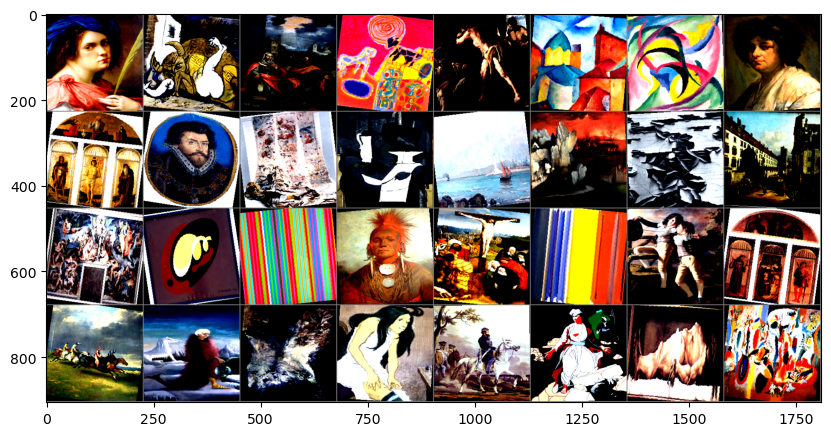

In [9]:
#Here I am printing the number of classes in dataset 
num_classes = len(train_dataset.dataset.classes)
print(f'Number of classes: {num_classes}')

#This is the function to see the dataset
def show_data(img):
    #as we have transformed image using normalisation so it will detransform it
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

im,label = next(iter(train_loader))
plt.figure(figsize=(10,12))
show_data(torchvision.utils.make_grid(im[:40]))

In [10]:
#This is the class for implementing ResNet50 with attention and GRU
class ResNet50GRUAttention(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50GRUAttention, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer
        
        #Adding the two layers of bidirectional GRU layers
        self.gru1 = nn.GRU(input_size=2048, hidden_size=256, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(input_size=512, hidden_size=128, batch_first=True, bidirectional=True)
        
        #Adding the attention layer
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)  
        
        #Here adding two dropout layer
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(256, 128)  # 256 is the hidden size of the attention output
        
        self.dropout2 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Reshape for ResNet
        batch_size, c, h, w = x.size()
        # Extract features using ResNet
        x = self.resnet(x)
        x = x.view(batch_size, 1, -1)
    
        # GRU layer
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        
        # Attention layer
        x = x.permute(1, 0, 2)  # Change shape to (sequence_length, batch_size, hidden_size)
        x, _ = self.attention(x, x, x)
        x = x.permute(1, 0, 2)  # Change shape back to (batch_size, sequence_length, hidden_size)
        
        # Flatten the sequence length dimension
        x = x.contiguous().view(batch_size, -1)
        
        # Dropout
        x = self.dropout1(x)
        # Fully connected layer
        x = self.fc1(x)
        
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

#Initilaizing device and resnet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = ResNet50GRUAttention(num_classes).to(device)

# Defining the loss and optimizer and scheduler function
criterion = nn.CrossEntropyLoss()

optimizer_sgd = optim.AdamW(resnet_model.parameters(), lr=0.00001, weight_decay=5e-4)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, 'min', factor=0.5, patience=5, min_lr=0.000001)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
print(resnet_model)

ResNet50GRUAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [30]:
# function for model training and recording its loss and accuracy
def train(model, trainloader, optimizer, criterion,scheduler):
    #training the model
    model.train()
    #initializing the loss and accuracy as 0
    training_loss = 0.0
    training_acc = 0
    count = 0
    #iterating through the training data
    for i, data in enumerate(trainloader):
        total=len(trainloader)
        count += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        #clearing previous gradient
        optimizer.zero_grad()
        #clearing cuda cache to free memory
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        # forward pass
        outputs = model(image)
        # calculating the loss
        loss = criterion(outputs, labels)
        #backward pass
        loss.backward()
        #optimization setp to update parameter
        optimizer.step()

        #calculating the loss
        training_loss += loss.item()
        # calculating the accuracy
        _, preds = torch.max(outputs.data, 1)
        training_acc += (preds == labels).sum().item()

        #printing the progress of training per epoch
        rate = (i + 1) / total
        a = "*" * int(rate * 50)
        b = "." * (50 - int(rate * 50))
        print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')

    #claculating the loss and accuracy over all batches
    epoch_loss = training_loss / count
    epoch_acc = 100. * (training_acc / len(trainloader.dataset))
    #stepping the scheduler based on loss per epoch
    scheduler.step(epoch_loss)
    
    # Logging the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    return epoch_loss, epoch_acc,current_lr


#this is the code for model validation
def validate(model, testloader, criterion):
    #setting the model on validating mode
    model.eval()
    #making a list to calculate accuracy for each model
    accurate_class = list(0. for i in range(10))
    total_class = list(0. for i in range(10))

    #initializing validation loss and accuracy
    validation_loss = 0.0
    validation_accuracy = 0
    count = 0

    #disabling gradient computation for validation
    with torch.no_grad():
        for i, data in enumerate(testloader):
            total=len(testloader)
            count += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
            # forward pass
            outputs = model(image)
            # calculating the loss
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # calculating  the accuracy
            _, preds = torch.max(outputs.data, 1)
            validation_accuracy += (preds == labels).sum().item()
            # calculating the accuracy for each class
            correct  = (preds == labels).squeeze()

            #printing per epoch to track
            rate = (i + 1) / total
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r test {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')
            
            for i in range(len(preds)):
                label = labels[i]
                accurate_class[label] += correct[i].item()
                total_class[label] += 1
    epoch_loss = validation_loss / count
    epoch_acc = 100. * (validation_accuracy / len(testloader.dataset))
    return epoch_loss, epoch_acc


#This is for training and validating the model calling required functions per epochs
def train_validate(model,optimizer,scheduler):
    #initializing empty list for loss and accuracy
    training_loss, validation_loss = [], []
    training_acc, validation_acc = [], []
    #calculating the total time
    time_taken = time.time()
    for epoch in range(epochs):
        print(f"[INFO][{datetime.datetime.now()}]: Epoch {epoch+1} of {epochs}")
        #calculating the time per epoch 
        start_time=time.time()

        #training the model
        train_epoch_loss, train_epoch_acc,lr = train(model, train_loader, optimizer, criterion,scheduler)
        #validating the model
        valid_epoch_loss, valid_epoch_acc = validate(model, test_loader,  criterion)
        #updating the loss and accuracy list
        training_loss.append(train_epoch_loss)
        validation_loss.append(valid_epoch_loss)
        training_acc.append(train_epoch_acc)
        validation_acc.append(valid_epoch_acc)
        #calculating the end time per epoch
        total_time=time.time()-start_time
        #printing details per epoch
        total_time= time.strftime('%H:%M:%S', time.gmtime(total_time))
        print(f"\rTraining loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, Learning rate: {lr} Time: {total_time}")

        print('-'*50)
        
    total_time_taken= time.strftime('%H:%M:%S', time.gmtime(time.time()-time_taken))
    print(f"\nFinal time taken to run total is::{total_time_taken}")
    return training_loss, validation_loss, training_acc, validation_acc

In [72]:
#Here I am calling the training and validating function
epochs=15
training_loss, validation_loss, training_acc, validation_acc= train_validate(resnet_model,optimizer_sgd,scheduler_sgd)


[INFO][2024-08-08 15:52:42.259699]: Epoch 1 of 15
Training loss: 1.606, training acc: 22.340, Validation loss: 1.594, validation acc: 22.881, Learning rate: 1e-05 Time: 00:02:25
--------------------------------------------------
[INFO][2024-08-08 15:55:08.212608]: Epoch 2 of 15
Training loss: 1.585, training acc: 34.043, Validation loss: 1.569, validation acc: 40.678, Learning rate: 1e-05 Time: 00:02:23
--------------------------------------------------
[INFO][2024-08-08 15:57:32.010998]: Epoch 3 of 15
Training loss: 1.560, training acc: 42.872, Validation loss: 1.528, validation acc: 54.237, Learning rate: 1e-05 Time: 00:02:25
--------------------------------------------------
[INFO][2024-08-08 15:59:57.213948]: Epoch 4 of 15
Training loss: 1.507, training acc: 48.830, Validation loss: 1.464, validation acc: 55.508, Learning rate: 1e-05 Time: 00:02:24
--------------------------------------------------
[INFO][2024-08-08 16:02:21.411652]: Epoch 5 of 15
Training loss: 1.435, training acc

In [32]:
#Here I am saving the model for inference
if not os.path.exists('./models'):
    os.makedirs('./models')
else:
    print('The file already exists')
save_path = './models/ResNet'
torch.save(resnet_model.state_dict(),save_path+'.pth')

The file already exists


In [11]:
#Here I am printing the classes for refrence
full_dataset = load_data(data_dir, transform=None)
classes=full_dataset.classes
print(classes)

['angry', 'fun', 'happy', 'neutral', 'sad']


In [12]:
#Here I am loading the model for evaluation mode 
resnet_model.load_state_dict(torch.load('models/ResNet.pth'))
resnet_model.eval()

# This is the function to classify image and return emotion label
def classify_emotion(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image).unsqueeze(0).cuda()
    with torch.no_grad():
        outputs = resnet_model(image)
        _, preds = torch.max(outputs, 1)
    return classes[preds.squeeze().tolist()]

## Emotion labelled MusicGen Fine tuning

In [56]:
#Using this I am creating a .txt file for each image based on their emotions
def emotion_text_label(file_path):
    with open(file_path, 'r') as f:
        file_data = json.load(f)

    for i in file_data:
        text_path=i['label']
        emotion_token= text_path.split('/')[1]
        os.makedirs(os.path.dirname(text_path), exist_ok=True)
        with open(text_path, 'w') as file:
                file.write(emotion_token)

In [57]:
#Here I am calling the defined function for training and validation this is based on ground truth
emotion_text_label('data_model/train_data.json')
emotion_text_label('data_model/val_data.json')

In [62]:
#Here I am calling the run function for fine tunining the MusicGen dataset for first approach i.e exploration using single emotion label
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=16 --lr=0.000001 --epochs=40 --save_file='model_base' --using_wandb=True 

2024-08-07 16:01:11.730537: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 16:01:11.772261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 16:01:11.772320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 16:01:11.773350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 16:01:11.779437: I tensorflow/core/platform/cpu_feature_guar

#### Some trials for this approach for finetuning

In [65]:
##### 
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=16 --lr=0.00002 --epochs=40 --save_file='lm_base'

2024-08-01 16:48:47.428093: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 16:48:47.495207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 16:48:47.495319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:48:47.496828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 16:48:47.513541: I tensorflow/core/platform/cpu_feature_guar

In [68]:
##### 
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=16 --lr=0.000001 --epochs=40 --save_file='lm_base_trial'

2024-08-01 19:51:07.805804: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 19:51:07.865635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 19:51:07.865759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 19:51:07.867419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 19:51:07.881917: I tensorflow/core/platform/cpu_feature_guar

In [45]:
####
!python3 run.py --dataset data_model --batch_size=16 --lr=0.000001 --epochs=40 --use_wandb=True --save_file='lm_base'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-07-23 16:37:26.280445: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 16:37:26.317515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 16:37:26.317572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 16:37:26.318522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 16:37:26.324004: I tensorflow/core/platform/cpu_feature_guar

# Model 2 - BLIP conditioned

In [13]:
#This function is for description of image conditioned on emotion this description will be used further for fine tuning MusicGen model
def emotion_image_caption(path_to_image,text):
    #Here I am getting pretrained Blip Large model
    img_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
    img_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)
    
    #Here I am converting image to RGB and the encoding it with processor further generating the output and then using the decoder to decod eit.
    raw_image = Image.open(path_to_image).convert('RGB')
    inputs = img_processor(raw_image, text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    out = img_model.generate(**inputs)
    
    text_token=img_processor.decode(out[0], skip_special_tokens=True)
    return text_token

In [11]:
#In this function I am getting the description of each image using BLip and then saving them in .txt file
def emotion_text_label(file_path):
    with open(file_path, 'r') as f:
        file_data = json.load(f)

    for i in file_data:
        text_path=i['label']
        emotion_token= text_path.split('/')[1]
        os.makedirs(os.path.dirname(text_path), exist_ok=True)
        image_path=text_path.replace('.txt','.jpg')
        text_token=emotion_image_caption(image_path,emotion_token)
        with open(text_path, 'w') as file:
                file.write(text_token)

In [84]:
#Here I am calling the defined function for each .json file which has train and eval dataset details
emotion_text_label('data_model/train_data.json')
emotion_text_label('data_model/val_data.json')

In [9]:
#Now I am finetuning my model based on these description
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=16 --lr=0.0001 --epochs=40 --using_wandb=True --save_file='model_blip'

2024-08-10 14:37:20.079665: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 14:37:20.143244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 14:37:20.143345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 14:37:20.144963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 14:37:20.154257: I tensorflow/core/platform/cpu_feature_guar

### Some trials for this model

In [85]:
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=16 --lr=0.000001 --epochs=40 --using_wandb=True --save_file='model_blip'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-08-07 21:21:17.550270: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 21:21:17.595312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 21:21:17.595371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 21:21:17.596464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 21:21:17.602635: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
!python3 run.py --dataset data_model --batch_size=16 --lr=0.000001 --epochs=40 --use_wandb=True --save_file='model_blip'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-07-23 22:12:03.307166: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 22:12:03.344175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 22:12:03.344240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 22:12:03.345357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 22:12:03.351442: I tensorflow/core/platform/cpu_feature_guar

# Model 3 - Enhanced description MusicGen Model

In [14]:
#This block and function is used to load Falcon 1B for enhancing the description to incorporate some musical terms 

# Here I am loading the tokenizer and model
model_name = 'ericzzz/falcon-rw-1b-instruct-openorca'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)

# Here I am initializing the pipeline of Falcon 1B
enhance_text_pipeline = pipeline(
   'text-generation',
   model=model,
   tokenizer=tokenizer,
   torch_dtype=torch.bfloat16,
   device=device,
)

#This function is for acessing the model 
def enhance_musical_description(description, max_length=150):
    # Here I am preparing the prompt and instruction for the model
    system_message = 'You are an enhanced description generator. You will be given with image description and you have to enhance those in musical terms.'
    instruction = f'Generate a musical theme description for the following image description: "{description}". Include details like mood, genre, tempo, and melody and piano in 2 lines'
    prompt = f'<SYS> {system_message} <INST> {instruction} <RESP> '

    # Here I am generating the enhanced description
    response = enhance_text_pipeline(
        prompt, 
        max_length=max_length,
        repetition_penalty=1.05,
        truncation=True,
    )

    # Now I am extracting and returning the generated description
    enhanced_description = response[0]['generated_text'].replace(prompt, "").strip()
    return enhanced_description


In [13]:
#This function i sto iterate over all the files and feed their description to model to enhance it

def enhance_label(file_path):
    with open(file_path, 'r') as f:
        file_data = json.load(f)
    for i in file_data:
        text_path=i['label']
        with open(text_path,'r') as file:
            description = file.read().strip()
        text_token=enhance_musical_description(description)
        with open(text_path, 'w') as file:
            file.write(text_token)

In [14]:
#Here I am passing both training and validation dataset
enhance_label('data_model/train_data.json')
enhance_label('data_model/valid_data.json')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `

FileNotFoundError: [Errno 2] No such file or directory: 'data_model/valid_data.json'

In [14]:
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=8 --lr=0.0001 --epochs=40 --use_cfg=True --using_wandb=True --save_file='model_falcon'

2024-08-13 11:18:19.862098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 11:18:19.920905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 11:18:19.921021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 11:18:19.922629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 11:18:19.932359: I tensorflow/core/platform/cpu_feature_guar

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
    self._bootstrap_inner()
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 48, in run
    self._run()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 99, in _run
    self._process(record)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 278, in _process
    self._hm.handle(record)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/handler.py", line 150, in handle
    handler(record)
 

### Some trials for this model

In [97]:
#Trial
!python3 run.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --batch_size=16 --lr=0.000001 --epochs=40 --use_wandb=True --save_file='lm_falcon'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-07-31 19:37:17.867868: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 19:37:17.910276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:37:17.910335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:37:17.911461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 19:37:17.917750: I tensorflow/core/platform/cpu_feature_guar

In [58]:
#Trial

!python3 run.py --dataset data_model --batch_size=16 --lr=0.000001 --epochs=40 --use_wandb=True --save_file='lm_falcon'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-07-24 06:44:49.052556: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 06:44:49.090376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 06:44:49.090441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 06:44:49.091641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 06:44:49.097879: I tensorflow/core/platform/cpu_feature_guar


KeyboardInterrupt



In [16]:
#Trial
!python3 run.py --dataset data_model --batch_size=16 --lr=0.000001 --epochs=40 --use_wandb=True --save_file='lm_falcon'

2024-07-30 22:29:11.528058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 22:29:11.569290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 22:29:11.569351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 22:29:11.570454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 22:29:11.576698: I tensorflow/core/platform/cpu_feature_guar

In [15]:
#Trial
!python3 run.py --dataset data_model --batch_size=16 --lr=0.0002 --epochs=40 --save_file='lm_falcon_trial'

2024-07-30 22:10:06.469572: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 22:10:06.512557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 22:10:06.512614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 22:10:06.513752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 22:10:06.520475: I tensorflow/core/platform/cpu_feature_guar

# Model 4 - Enhanced description with Modified MusicGen

In [78]:
##Final One

!python3 run_mod.py --train_dataset_path='data_model/train_data.json' --valid_dataset_path='data_model/val_data.json' --precompute_dir='processed_data' --batch_size=16 --lr=0.000001 --epochs=40 --save_file='lm_modify' --use_wandb=True

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-07-31 16:26:18.034260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 16:26:18.075342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 16:26:18.075395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 16:26:18.076503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 16:26:18.082733: I tensorflow/core/platform/cpu_feature_guar

### Some trials

In [23]:
###No need 
!python3 run_mod.py --dataset data_model --batch_size=16 --lr=0.000001 --epochs=40 --save_file='lm_modify'

2024-07-31 13:10:06.765346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 13:10:06.807176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 13:10:06.807240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 13:10:06.808347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 13:10:06.814547: I tensorflow/core/platform/cpu_feature_guar

In [21]:
#No need
!python3 run_mod.py --dataset data_model --batch_size=16 --lr=0.000002 --epochs=40  --save_file='lm_modify'

2024-07-31 12:39:59.043435: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 12:39:59.085870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 12:39:59.085928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 12:39:59.087072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 12:39:59.093345: I tensorflow/core/platform/cpu_feature_guar

# Test set music Generation

In [18]:
#This is for saving the json file
def save_json_file(path_json,labels_dict):
    with open(path_json, 'w') as json_file:
        json.dump(labels_dict, json_file, indent=4)
    print(f"Labels saved to {path_json}")

In [19]:
#This is for loading the test data file and making a list of images in the test set file

with open('data_model/test_data.json', 'r') as f:
    test_data = json.load(f)
seleceted_test_image=[]
for i in test_data:
    seleceted_test_image.append(i['label'].replace('.txt', '.jpg'))

In [17]:
# This function is to generate the audio file aclling the gen.py and passing the necessary arguments
def generate_audio(prompt_text, audio_filename,model_name):
    command = [
        'python', 'gen.py',
        '--prompt', prompt_text,
        '--weights_path', f'models/{model_name}.pt',
        '--save_path', audio_filename,
        '--duration', '30',
    ]
    print(f"Generating audio with prompt {prompt_text} saved as {audio_filename}")
    subprocess.run(command, check=True)


## Implementing the test set using first model

In [76]:
#Final One for first model

save_path= 'gen audio/1/'
os.makedirs(save_path, exist_ok=True)
output_json = 'gen audio/1/output_labels.json'
model_n='model_base_best'

output_label_dict1={}
for image_file in seleceted_test_image:
    emotion=classify_emotion(image_file)
    prompt_text=emotion
    audio_filename = os.path.join(save_path, f"{os.path.splitext(image_file.split('/')[-1])[0]}.wav")
    # print(audio_filename)
    generate_audio(prompt_text, audio_filename,model_n)
    output_label_dict1[audio_filename] = prompt_text
    # break

Generating audio with prompt sad saved as gen audio/1/sad_31_3.wav


2024-08-07 18:55:12.886382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:55:12.927293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 18:55:12.927340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:55:12.928348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 18:55:12.934287: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_30_4.wav


2024-08-07 18:56:03.604884: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:56:03.645945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 18:56:03.645997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:56:03.647041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 18:56:03.653075: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_24_5.wav


2024-08-07 18:56:55.763939: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:56:55.804630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 18:56:55.804681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:56:55.805718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 18:56:55.811704: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_31_1.wav


2024-08-07 18:57:47.815069: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:57:47.856431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 18:57:47.856486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:57:47.857497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 18:57:47.863424: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/sad_1_5.wav


2024-08-07 18:58:39.933192: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:58:39.973806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 18:58:39.973864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:58:39.974867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 18:58:39.980755: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_7_3.wav


2024-08-07 18:59:32.376549: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:59:32.417630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 18:59:32.417680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:59:32.418692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 18:59:32.424671: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_14_0.wav


2024-08-07 19:00:24.297193: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:00:24.338356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:00:24.338409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:00:24.339427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:00:24.345435: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_14_1.wav


2024-08-07 19:01:15.663474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:01:15.704787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:01:15.704826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:01:15.705836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:01:15.711721: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/sad_14_2.wav


2024-08-07 19:02:07.569260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:02:07.610106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:02:07.610154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:02:07.611171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:02:07.617146: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_9_0.wav


2024-08-07 19:02:59.580997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:02:59.621648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:02:59.621699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:02:59.622686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:02:59.628556: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/sad_33_0.wav


2024-08-07 19:03:51.878338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:03:51.924455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:03:51.924511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:03:51.925528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:03:51.931581: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_32_2.wav


2024-08-07 19:04:43.381210: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:04:43.421552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:04:43.421606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:04:43.422607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:04:43.428530: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_16_1.wav


2024-08-07 19:05:34.445349: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:05:34.486654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:05:34.486703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:05:34.487720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:05:34.493768: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_7_5.wav


2024-08-07 19:06:26.696686: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:06:26.737972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:06:26.738023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:06:26.739045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:06:26.745037: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_32_5.wav


2024-08-07 19:07:18.409994: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:07:18.450979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:07:18.451030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:07:18.452042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:07:18.458143: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_13_1.wav


2024-08-07 19:08:10.611476: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:08:10.651745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:08:10.651794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:08:10.652802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:08:10.658677: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/sad_32_0.wav


2024-08-07 19:09:03.817666: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:09:03.858492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:09:03.858545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:09:03.859571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:09:03.865632: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_20_4.wav


2024-08-07 19:09:56.396125: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:09:56.439666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:09:56.439714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:09:56.440710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:09:56.446698: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_31_6.wav


2024-08-07 19:10:49.001286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:10:49.042116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:10:49.042174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:10:49.043198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:10:49.049228: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_26_6.wav


2024-08-07 19:11:42.274567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:11:42.315823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:11:42.315891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:11:42.316900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:11:42.323063: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/sad_16_4.wav


2024-08-07 19:12:34.915832: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:12:34.958555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:12:34.958612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:12:34.959650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:12:34.965861: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_29_3.wav


2024-08-07 19:13:28.254128: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:13:28.295049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:13:28.295103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:13:28.296128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:13:28.302112: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_9_2.wav


2024-08-07 19:14:21.437284: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:14:21.478477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:14:21.478525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:14:21.479532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:14:21.485526: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_20_5.wav


2024-08-07 19:15:12.832030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:15:12.872811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:15:12.872870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:15:12.873875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:15:12.879873: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_38_2.wav


2024-08-07 19:16:05.143834: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:16:05.186047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:16:05.186100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:16:05.187126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:16:05.193276: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_26_5.wav


2024-08-07 19:16:58.223251: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:16:58.265502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:16:58.265558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:16:58.266564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:16:58.272581: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_36_3.wav


2024-08-07 19:17:52.038250: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:17:52.082213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:17:52.082273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:17:52.083309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:17:52.089303: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_41_4.wav


2024-08-07 19:18:45.080602: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:18:45.121774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:18:45.121823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:18:45.122831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:18:45.128795: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_33_0.wav


2024-08-07 19:19:38.156622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:19:38.197570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:19:38.197619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:19:38.198644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:19:38.204916: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_44_3.wav


2024-08-07 19:20:31.356183: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:20:31.396595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:20:31.396647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:20:31.397688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:20:31.403727: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_10_3.wav


2024-08-07 19:21:24.703237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:21:24.745751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:21:24.745802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:21:24.746808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:21:24.752722: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_43_2.wav


2024-08-07 19:22:16.787545: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:22:16.829584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:22:16.829639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:22:16.830653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:22:16.836623: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_42_5.wav


2024-08-07 19:23:09.168131: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:23:09.209521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:23:09.209574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:23:09.210586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:23:09.216557: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_45_9.wav


2024-08-07 19:24:01.459161: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:24:01.500007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:24:01.500055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:24:01.501075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:24:01.507044: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_9_3.wav


2024-08-07 19:24:53.068634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:24:53.109594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:24:53.109646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:24:53.110666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:24:53.116646: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_12_1.wav


2024-08-07 19:25:44.727646: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:25:44.768947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:25:44.769002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:25:44.770022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:25:44.776008: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_42_1.wav


2024-08-07 19:26:36.073836: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:26:36.114258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:26:36.114307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:26:36.115329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:26:36.121295: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_42_3.wav


2024-08-07 19:27:28.438124: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:27:28.479759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:27:28.479814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:27:28.480938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:27:28.487059: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_20_3.wav


2024-08-07 19:28:19.948297: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:28:19.989071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:28:19.989124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:28:19.990124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:28:19.996094: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad saved as gen audio/1/fun_39_3.wav


2024-08-07 19:29:13.238874: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:29:13.279767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:29:13.279818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:29:13.280811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:29:13.287017: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_35_5.wav


2024-08-07 19:30:04.896466: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:30:04.937454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:30:04.937513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:30:04.938863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:30:04.945705: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_44_2.wav


2024-08-07 19:30:55.805337: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:30:55.846114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:30:55.846162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:30:55.847186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:30:55.853098: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_36_1.wav


2024-08-07 19:31:48.569258: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:31:48.609867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:31:48.609917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:31:48.610955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:31:48.616958: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_20_7.wav


2024-08-07 19:32:40.958261: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:32:40.999375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:32:40.999430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:32:41.000456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:32:41.006561: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_35_0.wav


2024-08-07 19:33:32.953165: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:33:32.998146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:33:32.998210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:33:32.999240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:33:33.007063: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun saved as gen audio/1/fun_33_1.wav


2024-08-07 19:34:26.069239: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:34:26.109650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:34:26.109700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:34:26.110712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:34:26.116663: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_32_2.wav


2024-08-07 19:35:19.072350: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:35:19.112950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:35:19.112996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:35:19.114013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:35:19.119956: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_12_1.wav


2024-08-07 19:36:12.222622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:36:12.265673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:36:12.265727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:36:12.266747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:36:12.272702: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_29_3.wav


2024-08-07 19:37:04.515159: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:37:04.556117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:37:04.556169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:37:04.557177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:37:04.563145: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_9_4.wav


2024-08-07 19:37:56.508448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:37:56.549069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:37:56.549116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:37:56.550141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:37:56.556089: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_13_3.wav


2024-08-07 19:38:48.056054: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:38:48.097138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:38:48.097189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:38:48.098219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:38:48.104147: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_26_1.wav


2024-08-07 19:39:39.326103: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:39:39.367677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:39:39.367731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:39:39.368755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:39:39.374933: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_27_1.wav


2024-08-07 19:40:32.127919: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:40:32.168994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:40:32.169044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:40:32.170059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:40:32.176019: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_21_5.wav


2024-08-07 19:41:23.599515: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:41:23.640444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:41:23.640495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:41:23.641535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:41:23.647495: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_26_7.wav


2024-08-07 19:42:15.679360: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:42:15.720468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:42:15.720518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:42:15.721554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:42:15.727510: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_37_2.wav


2024-08-07 19:43:08.043830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:43:08.085271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:43:08.085326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:43:08.086363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:43:08.092365: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_47_2.wav


2024-08-07 19:43:59.368699: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:43:59.409428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:43:59.409475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:43:59.410496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:43:59.416464: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_34_6.wav


2024-08-07 19:44:51.689218: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:44:51.730696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:44:51.730744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:44:51.731784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:44:51.737801: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_17_3.wav


2024-08-07 19:45:43.237289: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:45:43.278804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:45:43.278864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:45:43.279969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:45:43.286024: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_22_4.wav


2024-08-07 19:46:34.318108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:46:34.359645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:46:34.359694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:46:34.360747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:46:34.366824: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_45_1.wav


2024-08-07 19:47:25.889004: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:47:25.929861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:47:25.929913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:47:25.930960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:47:25.936926: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_24_4.wav


2024-08-07 19:48:19.988192: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:48:20.030420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:48:20.030479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:48:20.031632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:48:20.037727: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_40_1.wav


2024-08-07 19:49:12.026190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:49:12.067038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:49:12.067091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:49:12.068116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:49:12.074108: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_4_5.wav


2024-08-07 19:50:04.364159: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:50:04.405059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:50:04.405112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:50:04.406134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:50:04.412137: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_7_2.wav


2024-08-07 19:50:56.366095: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:50:56.406780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:50:56.406831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:50:56.407860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:50:56.413848: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_10_3.wav


2024-08-07 19:51:48.442362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:51:48.484743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:51:48.484794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:51:48.485827: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:51:48.491881: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_23_2.wav


2024-08-07 19:52:41.670293: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:52:41.712464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:52:41.712538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:52:41.713711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:52:41.719886: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_4_2.wav


2024-08-07 19:53:33.804643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:53:33.845493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:53:33.845544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:53:33.846565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:53:33.852999: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_6_4.wav


2024-08-07 19:54:28.339265: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:54:28.382075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:54:28.382149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:54:28.383374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:54:28.389778: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_1_5.wav


2024-08-07 19:55:21.626299: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:55:21.667319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:55:21.667366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:55:21.668394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:55:21.674318: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/neutral_33_6.wav


2024-08-07 19:56:13.541740: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:56:13.582355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:56:13.582411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:56:13.583433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:56:13.589418: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_15_0.wav


2024-08-07 19:57:06.293501: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:57:06.336035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:57:06.336097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:57:06.337132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:57:06.343233: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_23_4.wav


2024-08-07 19:57:58.898620: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:57:58.939820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:57:58.939882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:57:58.940916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:57:58.947048: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_14_4.wav


2024-08-07 19:58:50.011795: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:58:50.053145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:58:50.053200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:58:50.054280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:58:50.060399: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_6_1.wav


2024-08-07 19:59:40.243348: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 19:59:40.284312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 19:59:40.284370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 19:59:40.285427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 19:59:40.291496: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_24_1.wav


2024-08-07 20:00:31.115756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:00:31.157442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:00:31.157505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:00:31.158603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:00:31.164827: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_5_10.wav


2024-08-07 20:01:31.443214: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:01:31.485065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:01:31.485127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:01:31.486239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:01:31.492493: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_8_4.wav


2024-08-07 20:02:23.652030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:02:23.693189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:02:23.693253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:02:23.694310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:02:23.700386: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/angry_20_7.wav


2024-08-07 20:03:15.238155: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:03:15.281249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:03:15.281308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:03:15.282467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:03:15.289147: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_25_2.wav


2024-08-07 20:04:07.408271: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:04:07.449970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:04:07.450034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:04:07.451176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:04:07.457458: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_5_27.wav


2024-08-07 20:05:00.631371: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:05:00.678952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:05:00.679010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:05:00.680112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:05:00.686485: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_22_6.wav


2024-08-07 20:05:53.771134: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:05:53.812227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:05:53.812287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:05:53.813351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:05:53.819468: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_10_3.wav


2024-08-07 20:06:46.341328: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:06:46.383510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:06:46.383577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:06:46.384686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:06:46.390972: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_6_4.wav


2024-08-07 20:07:38.772483: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:07:38.815506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:07:38.815591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:07:38.816722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:07:38.823108: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_17_0.wav


2024-08-07 20:08:31.707462: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:08:31.750098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:08:31.750157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:08:31.751294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:08:31.757535: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_22_8.wav


2024-08-07 20:09:23.603470: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:09:23.645265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:09:23.645322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:09:23.646388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:09:23.652439: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_22_11.wav


2024-08-07 20:10:15.326961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:10:15.368694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:10:15.368752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:10:15.369895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:10:15.376192: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_22_1.wav


2024-08-07 20:11:08.760278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:11:08.802160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:11:08.802245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:11:08.803982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:11:08.811123: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_10_7.wav


2024-08-07 20:12:01.233012: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:12:01.274403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:12:01.274461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:12:01.275536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:12:01.281632: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_7_3.wav


2024-08-07 20:13:01.965451: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:13:02.006450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:13:02.006510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:13:02.007575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:13:02.013683: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_11_3.wav


2024-08-07 20:13:53.903760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:13:53.945229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:13:53.945288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:13:53.946364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:13:53.953290: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry saved as gen audio/1/angry_16_2.wav


2024-08-07 20:14:46.994599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:14:47.039730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:14:47.039789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:14:47.040864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:14:47.047466: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_8_0.wav


2024-08-07 20:15:40.103412: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:15:40.151616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:15:40.151684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:15:40.152914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:15:40.159880: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_14_3.wav


2024-08-07 20:16:34.616386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:16:34.657316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:16:34.657380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:16:34.658406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:16:34.664417: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_20_2.wav


2024-08-07 20:17:28.538679: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:17:28.584210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:17:28.584276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:17:28.585267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:17:28.591242: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_37_1.wav


2024-08-07 20:18:20.493777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:18:20.534600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:18:20.534653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:18:20.535664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:18:20.541610: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_26_0.wav


2024-08-07 20:19:14.509239: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:19:14.552152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:19:14.552622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:19:14.555173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:19:14.562069: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_41_0.wav


2024-08-07 20:20:07.972752: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:20:08.016540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:20:08.016598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:20:08.017700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:20:08.023748: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_24_2.wav


2024-08-07 20:21:01.976124: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:21:02.020322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:21:02.020380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:21:02.021539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:21:02.027625: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_13_0.wav


2024-08-07 20:21:56.957448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:21:56.997724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:21:56.997777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:21:56.998800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:21:57.005475: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_21_7.wav


2024-08-07 20:22:49.591558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:22:49.634057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:22:49.634108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:22:49.635140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:22:49.641154: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_40_5.wav


2024-08-07 20:23:43.986899: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:23:44.028129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:23:44.028184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:23:44.029203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:23:44.035218: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_3_2.wav


2024-08-07 20:24:38.919211: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:24:38.961521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:24:38.961572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:24:38.962576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:24:38.968482: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_18_5.wav


2024-08-07 20:25:31.230613: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:25:31.271542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:25:31.271598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:25:31.272627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:25:31.278682: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_39_0.wav


2024-08-07 20:26:23.967268: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:26:24.008406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:26:24.008461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:26:24.009501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:26:24.015554: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_29_0.wav


2024-08-07 20:27:16.086507: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:27:16.128318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:27:16.128369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:27:16.129425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:27:16.135444: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_32_1.wav


2024-08-07 20:28:08.892889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:28:08.933893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:28:08.933953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:28:08.934965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:28:08.940960: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_11_3.wav


2024-08-07 20:29:01.459719: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:29:01.500506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:29:01.500562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:29:01.501611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:29:01.507667: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_8_5.wav


2024-08-07 20:29:55.453595: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:29:55.494431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:29:55.494488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:29:55.495507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:29:55.501476: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral saved as gen audio/1/happy_29_1.wav


2024-08-07 20:30:48.215475: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:30:48.258507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:30:48.258564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:30:48.259598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:30:48.265648: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_22_4.wav


2024-08-07 20:31:43.332371: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:31:43.376239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:31:43.376309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:31:43.377313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:31:43.383356: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_44_3.wav


2024-08-07 20:32:36.808767: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:32:36.854780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:32:36.854860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:32:36.856215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:32:36.862410: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_5_4.wav


2024-08-07 20:33:29.532206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:33:29.573130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:33:29.573184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:33:29.574209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:33:29.580211: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_5_0.wav


2024-08-07 20:34:23.109278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:34:23.152613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:34:23.152673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:34:23.153773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:34:23.160074: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_2_2.wav


2024-08-07 20:35:17.971271: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:35:18.011937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:35:18.011994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:35:18.013043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:35:18.019128: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_30_0.wav


2024-08-07 20:36:13.084399: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:36:13.127601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:36:13.127655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:36:13.128670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:36:13.134603: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy saved as gen audio/1/happy_33_2.wav


2024-08-07 20:37:07.600356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 20:37:07.644058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:37:07.644118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:37:07.645372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:37:07.651603: I tensorflow/core/platform/cpu_feature_guar

In [77]:
#Saving the json file here
save_json_file(output_json,output_label_dict1)

Labels saved to gen audio/1/output_labels.json


## Implementing the test set generation using second model

In [37]:
#Final One for second model

save_path= 'gen audio/2/'
os.makedirs(save_path, exist_ok=True)
# Traverse through each folder in the root directory
output_json = 'gen audio/2/output_labels.json'
model_n='model_blip_best'

output_label_dict2={}
for image_file in seleceted_test_image:
    emotion=classify_emotion(image_file)
    description=emotion_image_caption(image_file,emotion)
    prompt_text=description
    # print(prompt_text)
    audio_filename = os.path.join(save_path, f"{os.path.splitext(image_file.split('/')[-1])[0]}.wav")
    # print(audio_filename)
    generate_audio(prompt_text, audio_filename,model_n)
    output_label_dict2[audio_filename] = prompt_text
    # break

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generating audio with prompt sad man in a sailor's hat sitting at a table saved as gen audio/2/sad_31_3.wav


2024-08-09 17:59:03.367359: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 17:59:03.408256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 17:59:03.408316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 17:59:03.409256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 17:59:03.414840: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking man with a beard and a beardless face is surrounded by other people saved as gen audio/2/sad_30_4.wav


2024-08-09 17:59:57.854881: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 17:59:57.897335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 17:59:57.897409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 17:59:57.898587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 17:59:57.904259: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad flower in a vase, oil on canvas, 24 x 24 saved as gen audio/2/sad_24_5.wav


2024-08-09 18:00:50.992510: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:00:51.028901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:00:51.028958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:00:51.029925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:00:51.035806: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad woman sitting in a chair in front of a painting saved as gen audio/2/sad_31_1.wav


2024-08-09 18:01:52.571136: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:01:52.629666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:01:52.629759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:01:52.631374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:01:52.640472: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry landscape with a man on horseback and a group of men in the foreground saved as gen audio/2/sad_1_5.wav


2024-08-09 18:02:46.178401: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:02:46.236967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:02:46.237068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:02:46.238702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:02:46.248004: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking picture of a black and white picture of a map saved as gen audio/2/sad_7_3.wav


2024-08-09 18:03:40.352275: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:03:40.418474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:03:40.418563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:03:40.420225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:03:40.429613: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking man with bleeding face standing next to a painting of jesus saved as gen audio/2/sad_14_0.wav


2024-08-09 18:04:36.149571: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:04:36.209006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:04:36.209099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:04:36.210704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:04:36.219968: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking woman in a golden dress holding a book and a red flag saved as gen audio/2/sad_14_1.wav


2024-08-09 18:05:31.143631: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:05:31.202568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:05:31.202644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:05:31.204069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:05:31.212678: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of people in a dark room with a basket on the floor saved as gen audio/2/sad_14_2.wav


2024-08-09 18:06:24.087719: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:06:24.144721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:06:24.144799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:06:24.146244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:06:24.154736: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking woman sitting on a rock in a blue landscape saved as gen audio/2/sad_9_0.wav


2024-08-09 18:07:17.220980: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:07:17.281774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:07:17.281869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:07:17.283479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:07:17.292884: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry dog in the ocean, oil on canvas, 24 x 24 saved as gen audio/2/sad_33_0.wav


2024-08-09 18:08:10.441336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:08:10.497440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:08:10.497506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:08:10.498879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:08:10.506973: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking painting of a church in a snowy landscape with a few birds saved as gen audio/2/sad_32_2.wav


2024-08-09 18:09:05.822266: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:09:05.878722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:09:05.878801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:09:05.880368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:09:05.889044: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking picture of a bird flying over a forest saved as gen audio/2/sad_16_1.wav


2024-08-09 18:10:00.796647: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:10:00.855572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:10:00.855660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:10:00.857261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:10:00.866448: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad black square with a red line saved as gen audio/2/sad_7_5.wav


2024-08-09 18:10:58.491563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:10:58.545284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:10:58.545350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:10:58.546700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:10:58.554634: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking painting of a man laying on a bed with angels surrounding him saved as gen audio/2/sad_32_5.wav


2024-08-09 18:11:52.437780: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:11:52.476900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:11:52.476959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:11:52.478003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:11:52.483803: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking painting of a vase with flowers on a table saved as gen audio/2/sad_13_1.wav


2024-08-09 18:12:46.041650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:12:46.078964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:12:46.079037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:12:46.080036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:12:46.085974: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral painting of a woman with a green umbrella in a field saved as gen audio/2/sad_32_0.wav


2024-08-09 18:13:37.482391: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:13:37.546542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:13:37.546660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:13:37.548573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:13:37.559917: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad couple sitting on a green cushion, painting by paul delry saved as gen audio/2/sad_20_4.wav


2024-08-09 18:14:36.832700: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:14:36.897521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:14:36.897662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:14:36.899963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:14:36.909887: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad old man with guitar by the sea by pablo murill saved as gen audio/2/sad_31_6.wav


2024-08-09 18:15:57.228288: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:15:57.290508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:15:57.290608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:15:57.292222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:15:57.304923: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking statue of a woman laying on a bed with a sheet covering her saved as gen audio/2/sad_26_6.wav


2024-08-09 18:17:58.631281: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:17:58.687088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:17:58.687163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:17:58.688547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:17:58.700779: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking painting of a lone horse in a grassy field saved as gen audio/2/sad_16_4.wav


2024-08-09 18:19:07.100143: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:19:07.163695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:19:07.163757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:19:07.165142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:19:07.173423: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a group of people gathered around a statue saved as gen audio/2/fun_29_3.wav


2024-08-09 18:20:04.613208: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:20:04.672272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:20:04.672353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:20:04.673787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:20:04.682382: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man writing a letter with a dog saved as gen audio/2/fun_9_2.wav


2024-08-09 18:21:03.688176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:21:03.728782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:21:03.728845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:21:03.729817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:21:03.735435: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun statue of a woman with a veil on her head saved as gen audio/2/fun_20_5.wav


2024-08-09 18:22:01.532539: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:22:01.572001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:22:01.572060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:22:01.573049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:22:01.578907: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun painting of a woman in a red dress holding a bird saved as gen audio/2/fun_38_2.wav


2024-08-09 18:22:58.809500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:22:58.866678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:22:58.866760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:22:58.868284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:22:58.876934: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man with a red hat and a red scarf saved as gen audio/2/fun_26_5.wav


2024-08-09 18:23:58.023000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:23:58.087592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:23:58.087688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:23:58.089397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:23:58.099257: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a man standing in front of a crowd saved as gen audio/2/fun_36_3.wav


2024-08-09 18:25:01.115115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:25:01.177100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:25:01.177235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:25:01.178942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:25:01.188519: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a woman with a white headdress saved as gen audio/2/fun_41_4.wav


2024-08-09 18:25:58.356413: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:25:58.417538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:25:58.417632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:25:58.419318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:25:58.428944: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man with a bird in his hand saved as gen audio/2/fun_33_0.wav


2024-08-09 18:26:53.336558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:26:53.397075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:26:53.397182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:26:53.398899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:26:53.408493: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a family with a dog saved as gen audio/2/fun_44_3.wav


2024-08-09 18:27:47.880773: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:27:47.943564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:27:47.943723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:27:47.946103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:27:47.955853: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man in a blue coat and fur collar saved as gen audio/2/fun_10_3.wav


2024-08-09 18:28:44.395837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:28:44.456556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:28:44.456630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:28:44.458184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:28:44.466712: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt funeratori de la mano, fresco, frescoo, frescoo, frescoo, saved as gen audio/2/fun_43_2.wav


2024-08-09 18:29:40.400812: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:29:40.461519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:29:40.461616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:29:40.463267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:29:40.472674: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a man in a regal regal regal saved as gen audio/2/fun_42_5.wav


2024-08-09 18:30:39.362628: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:30:39.406457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:30:39.406521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:30:39.407700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:30:39.413944: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of jesus on the cross with other people saved as gen audio/2/fun_45_9.wav


2024-08-09 18:31:39.025245: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:31:39.089344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:31:39.089445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:31:39.091108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:31:39.101430: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun painting of a manger with a baby in a manger saved as gen audio/2/fun_9_3.wav


2024-08-09 18:32:47.199384: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:32:47.263038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:32:47.263137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:32:47.264784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:32:47.274730: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun lady in blue dress holding a rose in her hand saved as gen audio/2/fun_12_1.wav


2024-08-09 18:33:43.423506: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:33:43.486482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:33:43.486549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:33:43.487945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:33:43.500424: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a manger scene with a baby saved as gen audio/2/fun_42_1.wav


2024-08-09 18:34:44.763682: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:34:44.824301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:34:44.824406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:34:44.826191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:34:44.835997: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man with a beard and a hat saved as gen audio/2/fun_42_3.wav


2024-08-09 18:35:40.633190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:35:40.699955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:35:40.700079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:35:40.701746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:35:40.711224: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man in a military uniform with a bow tie saved as gen audio/2/fun_20_3.wav


2024-08-09 18:36:38.927873: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:36:38.989926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:36:38.990037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:36:38.991737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:36:39.001511: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt sad looking woman in a white headdress and a brown dress saved as gen audio/2/fun_39_3.wav


2024-08-09 18:37:39.486193: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:37:39.549515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:37:39.549586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:37:39.551041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:37:39.560433: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun poster of a man with a hat and tie with the words'soulless survivor ' saved as gen audio/2/fun_35_5.wav


2024-08-09 18:38:36.034398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:38:36.071565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:38:36.071620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:38:36.072635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:38:36.078790: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun painting of a woman with a goat in a mountainous area saved as gen audio/2/fun_44_2.wav


2024-08-09 18:39:29.997874: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:39:30.055335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:39:30.055410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:39:30.056900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:39:30.065943: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man in a regal regal regal regal regal regal regal regal regal regal regal regal saved as gen audio/2/fun_36_1.wav


2024-08-09 18:40:25.526736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:40:25.589945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:40:25.590087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:40:25.592514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:40:25.603114: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun picture of a painting of a man and a little girl saved as gen audio/2/fun_20_7.wav


2024-08-09 18:41:19.387570: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:41:19.426268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:41:19.426340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:41:19.427400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:41:19.433364: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man with blue eyes saved as gen audio/2/fun_35_0.wav


2024-08-09 18:42:11.635528: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:42:11.696303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:42:11.696416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:42:11.698195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:42:11.707856: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt fun portrait of a man in a gold and black jacket saved as gen audio/2/fun_33_1.wav


2024-08-09 18:43:08.406205: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:43:08.443055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:43:08.443121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:43:08.444171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:43:08.449744: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral background with a painting of a person and a clock saved as gen audio/2/neutral_32_2.wav


2024-08-09 18:44:00.224399: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:44:00.262087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:44:00.262139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:44:00.263145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:44:00.268997: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and yellow abstract painting of a woman in a flowing dress saved as gen audio/2/neutral_12_1.wav


2024-08-09 18:44:54.275250: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:44:54.335940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:44:54.336056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:44:54.337865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:44:54.347318: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and bold abstract painting of a man and woman saved as gen audio/2/neutral_29_3.wav


2024-08-09 18:45:49.443050: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:45:49.505097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:45:49.505224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:45:49.507032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:45:49.516634: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and bold abstract painting of a woman with a red dress saved as gen audio/2/neutral_9_4.wav


2024-08-09 18:46:42.483185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:46:42.521340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:46:42.521413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:46:42.522504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:46:42.528370: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and colorful painting of flowers in a vase on a table saved as gen audio/2/neutral_13_3.wav


2024-08-09 18:47:51.715090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:47:51.775391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:47:51.775488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:47:51.777264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:47:51.786798: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and colorful painting of a woman in a red dress with a rose saved as gen audio/2/neutral_26_1.wav


2024-08-09 18:49:13.415182: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:49:13.451364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:49:13.451422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:49:13.452501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:49:13.458348: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral abstract painting of a group of people with a red and blue umbrella saved as gen audio/2/neutral_27_1.wav


2024-08-09 18:50:06.371094: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:50:06.432156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:50:06.432284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:50:06.434485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:50:06.444573: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral colored drawing of a man in a chair with a beard saved as gen audio/2/neutral_21_5.wav


2024-08-09 18:51:04.350633: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:51:04.411677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:51:04.411754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:51:04.413258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:51:04.421577: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and black painting of a building with a pipe and a vase saved as gen audio/2/neutral_26_7.wav


2024-08-09 18:51:56.760790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:51:56.821577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:51:56.821689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:51:56.823442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:51:56.832847: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral, red, blue, green, and yellow abstract painting of a woman with a checkered saved as gen audio/2/neutral_37_2.wav


2024-08-09 18:52:52.511783: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:52:52.580182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:52:52.580288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:52:52.582072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:52:52.596867: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral mixed - media collage of a man with a guitar saved as gen audio/2/neutral_47_2.wav


2024-08-09 18:53:50.998705: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:53:51.061211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:53:51.061315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:53:51.063231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:53:51.073059: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral toned photograph of a statue of a woman holding a tree branch saved as gen audio/2/neutral_34_6.wav


2024-08-09 18:54:43.791767: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:54:43.852245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:54:43.852360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:54:43.854132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:54:43.863590: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral toned image of a man on a bench with a dog saved as gen audio/2/neutral_17_3.wav


2024-08-09 18:55:36.602154: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:55:36.663194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:55:36.663310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:55:36.665066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:55:36.674710: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral colored fabric with a lot of paint on it saved as gen audio/2/neutral_22_4.wav


2024-08-09 18:56:28.197375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:56:28.234943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:56:28.235015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:56:28.236149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:56:28.242100: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral black and white painting with red and blue lines saved as gen audio/2/neutral_45_1.wav


2024-08-09 18:57:22.676718: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:57:22.732274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:57:22.732365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:57:22.733865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:57:22.742367: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and bold stripes, by mark roth saved as gen audio/2/neutral_24_4.wav


2024-08-09 18:58:20.039036: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:58:20.101248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:58:20.101359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:58:20.103175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:58:20.112828: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and black abstract painting of a man with a hat and a cell phone saved as gen audio/2/neutral_40_1.wav


2024-08-09 18:59:16.233902: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 18:59:16.294592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 18:59:16.294694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 18:59:16.296393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 18:59:16.305595: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral painting of a man with a mirror and a woman with a green apple saved as gen audio/2/neutral_4_5.wav


2024-08-09 19:00:08.330161: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:00:08.367942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:00:08.368012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:00:08.369090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:00:08.375019: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral colored painting of a table with a plate of food and a bowl of fruit saved as gen audio/2/neutral_7_2.wav


2024-08-09 19:01:03.787985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:01:03.849962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:01:03.850089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:01:03.851892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:01:03.861726: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral colored painting of a variety of different shapes and sizes saved as gen audio/2/neutral_10_3.wav


2024-08-09 19:01:58.730373: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:01:58.765666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:01:58.765726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:01:58.766671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:01:58.772309: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral background with a painting of a butterfly and a red light saved as gen audio/2/neutral_23_2.wav


2024-08-09 19:02:53.060340: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:02:53.115375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:02:53.115440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:02:53.116870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:02:53.124935: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral blue abstract painting with a circular design saved as gen audio/2/neutral_4_2.wav


2024-08-09 19:03:47.749817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:03:47.808530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:03:47.808624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:03:47.810225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:03:47.819737: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral white rug with squares and dots saved as gen audio/2/neutral_6_4.wav


2024-08-09 19:04:44.513727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:04:44.573019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:04:44.573091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:04:44.574466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:04:44.582878: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and purple painting with a black stripe saved as gen audio/2/neutral_1_5.wav


2024-08-09 19:05:46.131279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:05:46.202027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:05:46.202143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:05:46.203763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:05:46.214088: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral background with a painting of a colorful abstract design saved as gen audio/2/neutral_33_6.wav


2024-08-09 19:06:48.409482: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:06:48.472860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:06:48.472965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:06:48.474658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:06:48.484017: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry man with a spear in a cave with other men saved as gen audio/2/angry_15_0.wav


2024-08-09 19:07:45.331183: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:07:45.391300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:07:45.391373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:07:45.392823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:07:45.401163: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking man with eyes and hands on head saved as gen audio/2/angry_23_4.wav


2024-08-09 19:08:46.962181: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:08:47.023044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:08:47.023135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:08:47.024777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:08:47.034306: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of a man and woman in a wooded landscape saved as gen audio/2/angry_14_4.wav


2024-08-09 19:09:47.081790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:09:47.141591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:09:47.141692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:09:47.143458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:09:47.153334: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of a man laying on a hill with a gun saved as gen audio/2/angry_6_1.wav


2024-08-09 19:10:45.339075: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:10:45.410803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:10:45.410919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:10:45.413579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:10:45.421960: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking red and orange painting with a lot of paint on it saved as gen audio/2/angry_24_1.wav


2024-08-09 19:11:39.956697: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:11:40.017395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:11:40.017461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:11:40.018889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:11:40.027252: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of a man in a boat with a woman in a red dress saved as gen audio/2/angry_5_10.wav


2024-08-09 19:12:37.248386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:12:37.303915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:12:37.303983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:12:37.305396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:12:37.315096: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry red painting of a man on a cross with a man in the background saved as gen audio/2/angry_8_4.wav


2024-08-09 19:13:34.579723: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:13:34.642146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:13:34.642229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:13:34.643722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:13:34.652217: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy birthday, a painting of a ship in the middle of the ocean saved as gen audio/2/angry_20_7.wav


2024-08-09 19:14:35.465934: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:14:35.527684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:14:35.527751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:14:35.529201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:14:35.537478: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry abstract painting of a group of people riding horses saved as gen audio/2/angry_25_2.wav


2024-08-09 19:15:35.187186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:15:35.258744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:15:35.258878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:15:35.260741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:15:35.270756: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of a man with a knife in his hand saved as gen audio/2/angry_5_27.wav


2024-08-09 19:16:32.571479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:16:32.635467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:16:32.635558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:16:32.637162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:16:32.646624: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry painting of a group of people in a rocky landscape saved as gen audio/2/angry_22_6.wav


2024-08-09 19:17:29.007542: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:17:29.082789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:17:29.082892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:17:29.084680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:17:29.095719: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry birds flying over a pile of skulls in a desert saved as gen audio/2/angry_10_3.wav


2024-08-09 19:18:35.885956: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:18:35.950692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:18:35.950783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:18:35.952408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:18:35.961506: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry woman in a red dress with a black umbrella saved as gen audio/2/angry_6_4.wav


2024-08-09 19:19:32.641643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:19:32.703469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:19:32.703554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:19:32.704958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:19:32.713426: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of a person walking in the rain saved as gen audio/2/angry_17_0.wav


2024-08-09 19:20:31.786335: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:20:31.852466: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:20:31.852573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:20:31.854218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:20:31.863755: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry abstract painting of a group of trees with orange and blue colors saved as gen audio/2/angry_22_8.wav


2024-08-09 19:21:29.479114: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:21:29.536592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:21:29.536662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:21:29.538475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:21:29.549836: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry knight on horseback with a skull and a skull in the background saved as gen audio/2/angry_22_11.wav


2024-08-09 19:22:24.966933: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:22:25.021929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:22:25.022010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:22:25.023395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:22:25.031852: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry eyes, charcoal on paper, 12 x 12, $ 200 saved as gen audio/2/angry_22_1.wav


2024-08-09 19:23:25.866457: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:23:25.924853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:23:25.924921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:23:25.926278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:23:25.934352: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry man being thrown from a tree by a group of men saved as gen audio/2/angry_10_7.wav


2024-08-09 19:24:25.956821: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:24:26.018641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:24:26.018741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:24:26.020423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:24:26.029881: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry looking painting of a boat in a harbor with a castle in the background saved as gen audio/2/angry_7_3.wav


2024-08-09 19:25:19.166698: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:25:19.227076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:25:19.227168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:25:19.228773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:25:19.238014: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry woman in green and black shirt with glasses saved as gen audio/2/angry_11_3.wav


2024-08-09 19:26:15.770659: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:26:15.830079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:26:15.830187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:26:15.831834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:26:15.841540: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt angry man and woman in a boat in a body of water saved as gen audio/2/angry_16_2.wav


2024-08-09 19:27:10.204993: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:27:10.242543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:27:10.242595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:27:10.243620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:27:10.249592: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy ladies with umbrellas walking in the rain by the water saved as gen audio/2/happy_8_0.wav


2024-08-09 19:28:08.145496: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:28:08.208641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:28:08.208708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:28:08.210909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:28:08.222446: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy people gather around a well - known painting of a rainbow saved as gen audio/2/happy_14_3.wav


2024-08-09 19:29:05.105782: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:29:05.165952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:29:05.166043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:29:05.167524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:29:05.176705: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy people riding horses in a mountainous landscape with a village saved as gen audio/2/happy_20_2.wav


2024-08-09 19:30:04.697588: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:30:04.759723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:30:04.759828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:30:04.761516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:30:04.771323: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy painting of a park with trees and a bench saved as gen audio/2/happy_37_1.wav


2024-08-09 19:31:02.242631: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:31:02.304421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:31:02.304540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:31:02.306382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:31:02.316268: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy birthday cake and oranges on a table with a white plate saved as gen audio/2/happy_26_0.wav


2024-08-09 19:31:57.848375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:31:57.910452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:31:57.910536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:31:57.912006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:31:57.919968: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy clowns in a crowd of people by a painting saved as gen audio/2/happy_41_0.wav


2024-08-09 19:32:51.961344: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:32:52.024038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:32:52.024127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:32:52.025839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:32:52.035875: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy couple walking down a path by a river with a red umbrella saved as gen audio/2/happy_24_2.wav


2024-08-09 19:33:44.891868: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:33:44.931119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:33:44.931172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:33:44.932276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:33:44.938584: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy people sitting at a table in a garden with a dog saved as gen audio/2/happy_13_0.wav


2024-08-09 19:34:36.869141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:34:36.926587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:34:36.926659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:34:36.928014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:34:36.936150: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy couple sitting on the beach with palm trees and a view of the ocean saved as gen audio/2/happy_21_7.wav


2024-08-09 19:35:33.506797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:35:33.566352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:35:33.566445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:35:33.568107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:35:33.578162: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy looking painting of a farm with a view of a farm saved as gen audio/2/happy_40_5.wav


2024-08-09 19:36:27.251607: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:36:27.313055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:36:27.313144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:36:27.314796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:36:27.324343: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy day at the river with a windmill and boats in the water saved as gen audio/2/happy_3_2.wav


2024-08-09 19:37:24.617924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:37:24.678833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:37:24.678903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:37:24.680280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:37:24.688606: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy people in a rowboat on a calm river with sailboats saved as gen audio/2/happy_18_5.wav


2024-08-09 19:38:19.734614: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:38:19.794332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:38:19.794431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:38:19.796084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:38:19.806027: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy couple in a park with an umbrella by a painting saved as gen audio/2/happy_39_0.wav


2024-08-09 19:39:13.896530: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:39:13.958832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:39:13.958918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:39:13.960665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:39:13.970552: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy woman in a garden with sheep and sheepdogs saved as gen audio/2/happy_29_0.wav


2024-08-09 19:40:08.118909: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:40:08.157001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:40:08.157060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:40:08.158094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:40:08.163858: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy woman in a garden with fruit and flowers by a fountain saved as gen audio/2/happy_32_1.wav


2024-08-09 19:41:06.137789: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:41:06.200866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:41:06.200947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:41:06.202502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:41:06.211265: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy family in a park with a dog and a bird saved as gen audio/2/happy_11_3.wav


2024-08-09 19:42:02.610539: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:42:02.662479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:42:02.662542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:42:02.663647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:42:02.669392: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy holidays are coming to the island of the dead saved as gen audio/2/happy_8_5.wav


2024-08-09 19:42:54.982092: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:42:55.042483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:42:55.042584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:42:55.044229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:42:55.053651: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt neutral and colorful abstract painting of a wave and a flower saved as gen audio/2/happy_29_1.wav


2024-08-09 19:43:52.822901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:43:52.877922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:43:52.878005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:43:52.879399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:43:52.887622: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy mountain scene with sheep and sheep in foreground by albert coleau saved as gen audio/2/happy_22_4.wav


2024-08-09 19:44:47.421782: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:44:47.483305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:44:47.483394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:44:47.485073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:44:47.494438: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy people gather outside a rustic building in a country setting saved as gen audio/2/happy_44_3.wav


2024-08-09 19:45:39.374804: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:45:39.435654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:45:39.435760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:45:39.437440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:45:39.446969: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy day at the beach, oil on canvas, 12 x 12 saved as gen audio/2/happy_5_4.wav


2024-08-09 19:46:31.392922: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:46:31.455320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:46:31.455432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:46:31.457130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:46:31.466924: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy man with dog by a river in a wooded setting saved as gen audio/2/happy_5_0.wav


2024-08-09 19:47:28.206037: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:47:28.242874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:47:28.242933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:47:28.243981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:47:28.249568: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy woman sitting at a table in a restaurant with other people saved as gen audio/2/happy_2_2.wav


2024-08-09 19:48:20.811964: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:48:20.873139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:48:20.873240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:48:20.874861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:48:20.884231: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy birthday card with a colorful painting of a tree and a bird saved as gen audio/2/happy_30_0.wav


2024-08-09 19:49:17.763980: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:49:17.800785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:49:17.800845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:49:17.801841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:49:17.807602: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt happy people riding in a horse drawn carriage on a dirt road saved as gen audio/2/happy_33_2.wav


2024-08-09 19:50:15.115791: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 19:50:15.176249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:50:15.176370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:50:15.178122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 19:50:15.187922: I tensorflow/core/platform/cpu_feature_guar

In [38]:
save_json_file(output_json,output_label_dict2)

Labels saved to gen audio/2/output_labels.json


## Implementing the test set using third model

In [98]:
#Final One for third model

save_path= 'gen audio/3/'
os.makedirs(save_path, exist_ok=True)
# Traverse through each folder in the root directory
output_json = 'gen audio/3/output_labels.json'
model_n='lm_falcon_best'

output_label_dict3={}
for image_file in seleceted_test_image:
    emotion=classify_emotion(image_file)
    description=emotion_image_caption(image_file,emotion)
    prompt_text=enhance_musical_description(description)
    # print(prompt_text)
    audio_filename = os.path.join(save_path, f"{os.path.splitext(image_file.split('/')[-1])[0]}.wav")
    # print(audio_filename)
    generate_audio(prompt_text, audio_filename,model_n)
    output_label_dict3[audio_filename] = prompt_text
    # break

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating audio with prompt The sad man in a sailor's hat sits at a table, creating a melancholic atmosphere with a slow-paced tempo and a somber melody played by the piano. saved as gen audio/3/sad_31_3.wav


2024-07-31 21:24:00.075105: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:24:00.117118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:24:00.117174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:24:00.118279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:24:00.124411: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking man with a beard and a beardless face is surrounded by other people, creating a melancholic atmosphere. The mood is somber, as it reflects the man's emotional state. The genre is likely to be a ballad or a slow-paced piece of music that evokes feelings of sadness and longing. The tempo could be slow and steady, while the melody might include gentle harmonies and a simple yet poignant melody. Lastly, the piano can play a prominent role in enhancing the overall soundscape, adding depth and emotion to the composition. saved as gen audio/3/sad_30_4.wav


2024-07-31 21:24:55.938332: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:24:55.979347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:24:55.979394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:24:55.980412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:24:55.986413: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad flower in a vase, oil on canvas, is a melancholic piece that evokes feelings of sorrow and longing through its rich colors and expressive brushstrokes. The mood is somber, with a slow-paced tempo and a haunting melody played by the piano. saved as gen audio/3/sad_24_5.wav


2024-07-31 21:25:50.640913: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:25:50.681268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:25:50.681311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:25:50.682319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:25:50.688170: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad woman sits in a chair in front of a painting, creating a melancholic atmosphere with a slow-paced tempo and a somber melody played by the piano. saved as gen audio/3/sad_31_1.wav


2024-07-31 21:26:45.500984: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:26:45.542949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:26:45.543002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:26:45.544141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:26:45.550395: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry landscape features a man on horseback and a group of men in the foreground, creating a tense atmosphere that evokes feelings of conflict and tension. The music is characterized by a strong, driving beat, which sets the pace for the scene. saved as gen audio/3/sad_1_5.wav


2024-07-31 21:27:39.321820: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:27:39.362931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:27:39.362985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:27:39.364049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:27:39.370116: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking picture depicts a black and white map with a melancholic atmosphere, evoking feelings of nostalgia or exploration. The music is characterized by a slow tempo, reminiscent of a somber symphony, while the piano plays a melodic tune that complements the overall tone. saved as gen audio/3/sad_7_3.wav


2024-07-31 21:28:32.658357: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:28:32.700108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:28:32.700165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:28:32.701271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:28:32.707479: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking man with a bleeding face stands next to a painting of Jesus, creating a melancholic atmosphere that evokes feelings of loss and sorrow. saved as gen audio/3/sad_14_0.wav


2024-07-31 21:29:26.263945: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:29:26.305739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:29:26.305795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:29:26.306868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:29:26.312985: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking woman in a golden dress is wearing a red flag as she holds a book and a red flag, creating a sense of patriotism and strength. The music can be described as having a slow, melancholic pace with a hint of nostalgia, while also incorporating elements of patriotism and strength. saved as gen audio/3/sad_14_1.wav


2024-07-31 21:30:20.301552: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:30:20.342477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:30:20.342532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:30:20.343615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:30:20.349723: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts people in a dimly lit room, surrounded by a basket on the floor. The mood is described as tense and unsettling, while the genre leans towards the abstract or surreal. The tempo is slow and deliberate, with a hint of tension. The melody is haunting and evocative, while the piano adds a melancholic touch to the overall atmosphere. saved as gen audio/3/sad_14_2.wav


2024-07-31 21:31:30.518393: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:31:30.559336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:31:30.559394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:31:30.560463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:31:30.566558: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking woman is sitting on a rock in a blue landscape, which creates a melancholic atmosphere with a slow tempo and a somber melody. saved as gen audio/3/sad_9_0.wav


2024-07-31 21:32:52.684245: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:32:52.725305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:32:52.725359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:32:52.726434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:32:52.732616: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry dog in the ocean, oil on canvas, is a vibrant representation of nature's fury, capturing the essence of the sea with its vivid colors and powerful emotions. The mood evokes a sense of unrest and chaos, while the genre leans towards abstract expressionism, as it combines elements of realism and abstraction seamlessly. The tempo is fast-paced, with a strong beat that keeps the audience engaged. Lastly, the melody is hauntingly beautiful, creating a sense of longing and sorrow. saved as gen audio/3/sad_33_0.wav


2024-07-31 21:34:00.016919: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:34:00.057933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:34:00.057986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:34:00.059065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:34:00.065131: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a church nestled in a snowy landscape, where a few birds gracefully perch on the branches above. The mood is melancholic, evoking feelings of loneliness and longing amidst the serene setting. The genre is religious art, as it represents a place of worship and spiritual connection. The tempo is slow, allowing the viewer to appreciate the artist's skillful use of color and composition. Lastly, the melody is gentle, evoking a sense of peace and tranquility. saved as gen audio/3/sad_32_2.wav


2024-07-31 21:34:54.315181: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:34:54.356079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:34:54.356133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:34:54.357208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:34:54.363294: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking picture depicts a bird flying over a forest, evoking feelings of melancholy and nostalgia. The mood is melancholic, with elements of slow tempos and gentle melodies that evoke a sense of longing or sadness. saved as gen audio/3/sad_16_1.wav


2024-07-31 21:35:47.930139: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:35:47.971002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:35:47.971054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:35:47.972102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:35:47.978144: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad black square with a red line is characterized by its melancholic atmosphere, evoking feelings of sadness and longing. The music can be described as slow-paced, evocative, and evocative, with a hint of melancholy. saved as gen audio/3/sad_7_5.wav


2024-07-31 21:36:50.401219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:36:50.442618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:36:50.442670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:36:50.443718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:36:50.449764: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a man lying on a bed with angels surrounding him, creating a melancholic atmosphere that evokes feelings of loss or sorrow. The music is characterized by a slow tempo, evoking a sense of melancholy, while also featuring a melodic piano piece that adds to the overall emotional impact. saved as gen audio/3/sad_32_5.wav


2024-07-31 21:37:44.233761: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:37:44.275010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:37:44.275068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:37:44.276147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:37:44.282325: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a vase with flowers on a table, creating a melancholic atmosphere that evokes feelings of nostalgia or sorrow. The music can be described as slow, emotional, and evocative, with a focus on the piano's melodic and harmonic elements. saved as gen audio/3/sad_13_1.wav


2024-07-31 21:38:38.281079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:38:38.323029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:38:38.323090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:38:38.324202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:38:38.330539: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral painting depicts a woman with a green umbrella in a field, creating a serene atmosphere that evokes a sense of calmness and tranquility. The music can be described as a soothing, melodic composition that complements the overall aesthetic of the scene. saved as gen audio/3/sad_32_0.wav


2024-07-31 21:39:33.278336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:39:33.320195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:39:33.320251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:39:33.321381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:39:33.327612: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad couple is sitting on a green cushion, surrounded by a beautiful painting of Paul Delry, which creates a serene atmosphere that reflects their emotional state. The mood is melancholic, with a slow-paced tempo and a gentle melody played by the piano. saved as gen audio/3/sad_20_4.wav


2024-07-31 21:40:27.759222: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:40:27.801700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:40:27.801756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:40:27.802885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:40:27.809333: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad old man with guitar by the sea is a melancholic composition that evokes feelings of nostalgia and melancholy, featuring a slow-paced tempo and a melodic piano piece. saved as gen audio/3/sad_31_6.wav


2024-07-31 21:41:30.317748: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:41:30.358568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:41:30.358621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:41:30.359678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:41:30.365716: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking statue of a woman lying on a bed with a sheet covering her is reminiscent of a melancholic scene that evokes feelings of loneliness and longing. The music can be described as slow, emotional, and evocative, with a strong sense of nostalgia. saved as gen audio/3/sad_26_6.wav


2024-07-31 21:42:33.001478: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:42:33.043238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:42:33.043298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:42:33.044372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:42:33.050411: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a solitary horse in a lush, green grassy field, evoking feelings of loneliness and longing. The mood is melancholic, with a slow tempo and a somber melody played by the piano. saved as gen audio/3/sad_16_4.wav


2024-07-31 21:43:25.300409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:43:25.341391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:43:25.341442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:43:25.342518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:43:25.348659: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as upbeat melodies, energetic rhythms, and catchy lyrics that evoke a sense of celebration or camaraderie among the gathered group of people. saved as gen audio/3/fun_29_3.wav


2024-07-31 21:44:19.620796: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:44:19.662052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:44:19.662110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:44:19.663203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:44:19.669312: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and lively musical theme for this image could be described as "A cheerful and upbeat tune that captures the essence of a happy moment." The genre is likely to be related to music or storytelling, while the tempo is lively and engaging. Additionally, it includes elements such as a man writing a letter with a dog, which adds a playful element to the scene. saved as gen audio/3/fun_9_2.wav


2024-07-31 21:45:23.495145: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:45:23.539405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:45:23.539466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:45:23.540581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:45:23.546849: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun statue of a woman with a veil on her head is a captivating piece that evokes a sense of joy and celebration. The mood is lighthearted and whimsical, while the genre leans towards classical music. The tempo is lively and upbeat, and the melody features a catchy tune that will be memorable to those who hear it. saved as gen audio/3/fun_20_5.wav


2024-07-31 21:46:17.225299: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:46:17.266339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:46:17.266390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:46:17.267461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:46:17.273516: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun painting depicts a woman in a red dress holding a bird, creating a lively atmosphere with its vibrant colors and energetic composition. The mood is playful and whimsical, while the genre leans towards folk music or light-hearted tunes. The tempo is lively and upbeat, perfect for a cheerful scene. Lastly, the melody features catchy harmonies that will make you want to sing along. saved as gen audio/3/fun_38_2.wav


2024-07-31 21:47:19.649135: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:47:19.690140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:47:19.690193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:47:19.691276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:47:19.697427: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a catchy melody, upbeat tempo, and a playful rhythm. Here's a brief description:

"Fun Portrait of a Man with a Red Hat and Red Scarf"

1. Mood: Fun and lively
2. Genre: Musical
3. Tempo: Upbeat and energetic
4. Melody: A catchy tune that evokes emotions
5. Piano: An instrumental piece to enhance the overall atmosphere saved as gen audio/3/fun_26_5.wav


2024-07-31 21:48:23.431461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:48:23.475494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:48:23.475552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:48:23.476700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:48:23.483087: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a lively scene where a man is depicted as he stands in front of a large group of people, creating a vibrant atmosphere that reflects the energy and excitement of the moment. The genre can be described as upbeat and energetic, with elements such as rhythm, melody, and piano contributing to the overall feel of the composition. saved as gen audio/3/fun_36_3.wav


2024-07-31 21:49:27.252684: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:49:27.293876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:49:27.293922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:49:27.294995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:49:27.301092: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a vibrant scene where a woman is depicted as a painter, wearing a white headdress, creating a captivating composition that evokes a sense of celebration and joy. saved as gen audio/3/fun_41_4.wav


2024-07-31 21:50:21.356338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:50:21.398333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:50:21.398384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:50:21.399529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:50:21.405822: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and whimsical musical theme for this image could be described as "A delightful blend of folk-inspired melodies and lively rhythms." saved as gen audio/3/fun_33_0.wav


2024-07-31 21:51:24.787248: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:51:24.829178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:51:24.829228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:51:24.830362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:51:24.836662: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a family with a dog enjoying a lively scene, creating a cheerful atmosphere that reflects a warm and inviting ambiance. The genre is characterized by elements such as upbeat melodies, energetic rhythms, and a playful spirit. saved as gen audio/3/fun_44_3.wav


2024-07-31 21:52:20.982966: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:52:21.027083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:52:21.027150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:52:21.028318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:52:21.034730: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a catchy melody, upbeat tempo, and a playful atmosphere. Here's a brief description:

"Fun Portrait of a Man in a Blue Coat and Fur Collar"

1. Mood: The mood is lighthearted and celebratory, with a sense of joy and happiness.
2. Genre: This could be interpreted as a 'pop' or 'rock' style, which would involve catchy melodies, energetic rhythms, and memorable lyrics.
3. Tempo: The tempo is lively and upbeat, with a driving beat that keeps the audience engaged.
4. Melody: A simple yet catchy saved as gen audio/3/fun_10_3.wav


2024-07-31 21:53:17.191563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:53:17.232946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:53:17.232996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:53:17.234086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:53:17.240214: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The funereal procession with its vibrant frescoes, lively fresco-fresco, and energetic fresco-fresco creates a celebratory atmosphere that evokes a sense of joy and celebration. saved as gen audio/3/fun_43_2.wav


2024-07-31 21:54:20.688753: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:54:20.730005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:54:20.730054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:54:20.731147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:54:20.737268: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and lively musical theme for this image could be described as "Royal Regal Royal." The mood is celebratory and festive, with elements of royalty, grandeur, and elegance. saved as gen audio/3/fun_42_5.wav


2024-07-31 21:55:23.369241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:55:23.410893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:55:23.410945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:55:23.412045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:55:23.418230: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a scene where Jesus is depicted as he is on the cross, surrounded by various individuals who share his suffering. The atmosphere is filled with a sense of sorrow and empathy, creating a somber yet uplifting ambiance. saved as gen audio/3/fun_45_9.wav


2024-07-31 21:56:17.872273: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:56:17.914834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:56:17.914894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:56:17.916056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:56:17.922373: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun painting depicts a scene where a manger is filled with a baby, creating a warm and cozy atmosphere. The genre can be described as whimsical or nostalgic, while the tempo could be lively and energetic. Lastly, the melody may include elements of folk, pop, or classical music, depending on the artist's preference. saved as gen audio/3/fun_9_3.wav


2024-07-31 21:57:12.071646: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:57:12.113372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:57:12.113420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:57:12.114539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:57:12.121434: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun lady in blue dress is holding a beautiful rose in her hand, creating a lively atmosphere with a touch of romance and femininity. The music can be described as upbeat, energetic, and spirited, while maintaining a lighthearted tone. saved as gen audio/3/fun_12_1.wav


2024-07-31 21:58:05.885047: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:58:05.926574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:58:05.926630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:58:05.927766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:58:05.934054: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a happy, festive atmosphere, a catchy melody, and a gentle, soothing piano accompaniment. Here's a brief description:

"A joyful and heartwarming scene featuring a beautifully rendered manger scene with a cute little baby, creating a warm and inviting atmosphere." saved as gen audio/3/fun_42_1.wav


2024-07-31 21:58:59.546272: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:58:59.587533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:58:59.587587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:58:59.588672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:58:59.594761: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a catchy melody, upbeat tempo, and a harmonious blend of instruments (piano). saved as gen audio/3/fun_42_3.wav


2024-07-31 21:59:53.319574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 21:59:53.360729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 21:59:53.360779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 21:59:53.361849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 21:59:53.367896: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements from various genres such as pop, rock, or even classical music. The main focus should be on the upbeat and energetic nature of the theme, which will make it suitable for various types of media and events.

1. Mood: Fun and lively
2. Genre: Pop, Rock, or Classical
3. Tempo: Fast-paced and energetic
4. Melody: A catchy and memorable tune that evokes emotions
5. Piano: An instrumental piece that complements the overall theme saved as gen audio/3/fun_20_3.wav


2024-07-31 22:00:48.433546: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:00:48.474864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:00:48.474918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:00:48.475979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:00:48.482078: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking woman is wearing a white headdress and a brown dress, which creates a somber atmosphere with a slow tempo and a melancholic melody. saved as gen audio/3/fun_39_3.wav


2024-07-31 22:01:42.821356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:01:42.862313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:01:42.862362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:01:42.863450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:01:42.869575: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun poster features a man wearing a hat and tie, surrounded by the word "soulless" which implies a dark or sinister tone, while also incorporating elements of humor and energy. The overall atmosphere is upbeat and energetic, making it suitable for various genres such as comedy, drama, or even film scores. saved as gen audio/3/fun_35_5.wav


2024-07-31 22:02:46.435668: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:02:46.477452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:02:46.477503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:02:46.478583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:02:46.484705: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun painting depicts a woman with a goat in a mountainous area, creating a lively atmosphere that evokes a sense of adventure and exploration. The mood is lighthearted and whimsical, while the genre leans towards folk music or country-inspired tunes. The tempo is lively and upbeat, with a touch of nostalgia from the time when people would gather around to watch the artist paint. Lastly, the melody features a catchy tune that will be memorable for both the viewer and the listener. saved as gen audio/3/fun_44_2.wav


2024-07-31 22:03:41.028322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:03:41.069496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:03:41.069554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:03:41.070651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:03:41.076771: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and lively musical theme for this image could be described as "A Royal Reel" or "Royal Reel." The mood is celebratory and festive, with elements of royalty, regality, and grandeur. It's a perfect fit for a royal celebration, such as a wedding, formal event, or even a royal gathering. saved as gen audio/3/fun_36_1.wav


2024-07-31 22:04:36.020758: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:04:36.061715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:04:36.061772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:04:36.063019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:04:36.069191: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a lively scene with a man and a young girl, creating a vibrant atmosphere that evokes a sense of joy and happiness. The genre is likely to be a children's storybook or fairytale, while the tempo could be lively and upbeat, and the melody might feature catchy tunes and memorable melodies. saved as gen audio/3/fun_20_7.wav


2024-07-31 22:05:30.144897: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:05:30.187570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:05:30.187626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:05:30.188739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:05:30.194952: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created for this image by incorporating elements such as a catchy melody, upbeat tempo, and a touch of piano. The mood could be described as energetic and playful, while the genre is likely to fall under the category of pop or contemporary music. saved as gen audio/3/fun_35_0.wav


2024-07-31 22:06:33.092274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:06:33.133454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:06:33.133504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:06:33.134602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:06:33.140711: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as upbeat energy, catchy melodies, and a rhythmic beat. The theme could be inspired by the image's subject (a man wearing a gold and black jacket), or it could be more abstract based on the overall atmosphere. saved as gen audio/3/fun_33_1.wav


2024-07-31 22:07:26.870786: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:07:26.913808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:07:26.913869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:07:26.914975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:07:26.921152: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral background with a painting of a person and a clock creates a calm and serene atmosphere, which is further enhanced by the rhythmic rhythm of the clock's tick-tock. saved as gen audio/3/neutral_32_2.wav


2024-07-31 22:08:20.410510: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:08:20.451848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:08:20.451892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:08:20.453010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:08:20.459191: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and yellow abstract painting depicts a woman in a flowing dress, creating a visually striking scene that evokes a sense of calm and tranquility. The mood is described as neutral, which implies a lack of strong emotions or strong contrasts, while the genre leans towards abstraction, suggesting a more abstract approach to art. Additionally, the tempo is slow-paced, with a gentle rhythm that complements the overall atmosphere of the painting. Lastly, the melody is composed of piano notes, providing a soothing and harmonious background for the viewer's experience. saved as gen audio/3/neutral_12_1.wav


2024-07-31 22:09:15.944260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:09:15.985955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:09:15.986004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:09:15.987113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:09:15.993248: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and bold abstract painting depicts a man and woman, with their emotions expressed through their facial expressions and body language. The mood is described as neutral, which implies a calm and serene atmosphere, while the genre is categorized as abstract, suggesting that it may be related to visual art or other forms of expression. The tempo is also mentioned, indicating that the music should be slow and soothing, evoking feelings of relaxation and contemplation. Lastly, the melody and piano are included in two lines, providing more specific information about the composition's overall sound and emotional impact. saved as gen audio/3/neutral_29_3.wav


2024-07-31 22:10:12.018617: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:10:12.059702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:10:12.059752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:10:12.060851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:10:12.066966: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and bold abstract painting depicts a woman wearing a red dress, creating a striking visual composition that evokes a sense of calm and elegance. The mood is described as both neutral and bold, reflecting the artist's ability to create a harmonious balance between these two opposing qualities. The genre is characterized by abstraction, which showcases the artist's unique style and artistic vision. The tempo is also described as slow-paced, allowing the viewer to appreciate the intricate details and colors within the painting. Lastly, the melody is played on a piano, providing a soothing and relaxing atmosphere while immersing oneself in the artwork. saved as gen audio/3/neutral_9_4.wav


2024-07-31 22:11:06.519750: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:11:06.561042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:11:06.561092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:11:06.562207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:11:06.568327: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and colorful painting of flowers in a vase on a table evokes a sense of calm and serenity, with its vibrant hues and harmonious composition. The mood is peaceful and soothing, while the genre leans towards the abstract and impressionist styles. The tempo is slow and meditative, with gentle melodies that evoke feelings of nostalgia or celebration. saved as gen audio/3/neutral_13_3.wav


2024-07-31 22:12:06.500959: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:12:06.542232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:12:06.542281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:12:06.543360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:12:06.549431: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and colorful painting depicts a woman wearing a red dress adorned with a rose, creating a vibrant and lively atmosphere. The mood is described as both neutral and colorful, evoking feelings of tranquility and warmth. The genre can be categorized as abstract or impressionist, while the tempo is slow and meditative, allowing the viewer to appreciate the artist's skillful use of color and form. Lastly, the melody is soft and soothing, providing a sense of serenity and harmony. saved as gen audio/3/neutral_26_1.wav


2024-07-31 22:13:01.132500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:13:01.173824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:13:01.173880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:13:01.174968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:13:01.181037: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral abstract painting depicts a group of people with a red and blue umbrella, creating a harmonious atmosphere that evokes a sense of unity and connection. The mood is described as neutral, which implies a calm and serene environment, while the genre is categorized as abstract, suggesting a non-representational style. Additionally, the tempo is slow, providing a meditative experience, and the melody is melodic, reflecting the harmony between the colors and shapes. Lastly, the piano plays a prominent role, adding depth to the overall composition. saved as gen audio/3/neutral_27_1.wav


2024-07-31 22:14:04.269141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:14:04.311768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:14:04.311832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:14:04.313004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:14:04.319410: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored drawing depicts a man sitting in a chair with a beard, creating a relaxed atmosphere that could be associated with various genres such as folk, indie, or even lounge music. The tempo is slow and soothing, while the melody can evoke feelings of nostalgia or relaxation. saved as gen audio/3/neutral_21_5.wav


2024-07-31 22:15:00.125386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:15:00.166510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:15:00.166565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:15:00.167663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:15:00.173854: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and black painting depicts a building with a pipe and a vase, creating a harmonious composition that evokes a sense of tranquility and elegance. The mood is calm and serene, while the genre leans towards the classical or traditional style. The tempo is slow and steady, allowing the listener to appreciate the intricate details of the artwork. Lastly, the melody is soft and soothing, providing a relaxing atmosphere as you listen to this captivating piece. saved as gen audio/3/neutral_26_7.wav


2024-07-31 22:15:55.399857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:15:55.440809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:15:55.440859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:15:55.441969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:15:55.448079: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral, red, blue, green, and yellow abstract painting of a woman with a checkered features a vibrant and energetic atmosphere, evoking feelings of calmness and positivity. The composition is characterized by its rhythmic nature, with elements such as the colors, the woman's pose, and the use of various instruments (piano) creating a harmonious symphony that captivates the viewer. saved as gen audio/3/neutral_37_2.wav


2024-07-31 22:16:49.518483: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:16:49.559499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:16:49.559552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:16:49.560646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:16:49.566812: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral mixed-media collage features a man with a guitar, creating a harmonious atmosphere that evokes a sense of tranquility and creativity. The mood is relaxed and reflective, while the genre leans towards folk or acoustic music. The tempo is slow and steady, allowing the listener to savor the melodic elements of the song. Lastly, the melody is reminiscent of traditional folk tunes, while the piano adds a touch of sophistication. saved as gen audio/3/neutral_47_2.wav


2024-07-31 22:17:42.942309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:17:42.983575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:17:42.983626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:17:42.984731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:17:42.990903: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral toned photograph depicts a woman holding a tree branch, creating a visually striking scene that evokes a sense of tranquility and nature. The mood is contemplative, with elements of romance and nostalgia, while the genre leans towards classical music. The tempo is slow and steady, allowing the listener to appreciate the beauty of the composition. Lastly, the melody features a harmonious blend of strings and piano, providing a rich and emotive experience. saved as gen audio/3/neutral_34_6.wav


2024-07-31 22:18:37.020745: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:18:37.062319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:18:37.062372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:18:37.063478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:18:37.069624: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral toned image of a man on a bench with a dog creates a calm and serene atmosphere, evoking feelings of relaxation and connection to nature. The mood is peaceful and reflective, while the genre leans towards a more relaxed or laid-back style. The tempo is slow and soothing, with a gentle melody that complements the overall ambiance. saved as gen audio/3/neutral_17_3.wav


2024-07-31 22:19:39.304041: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:19:39.345085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:19:39.345142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:19:39.346226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:19:39.352392: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored fabric is adorned with a significant amount of paint, creating a vibrant and energetic atmosphere that reflects the artist's creative process. The music can be described as upbeat, featuring a strong beat and catchy melodies that keep the audience engaged. saved as gen audio/3/neutral_22_4.wav


2024-07-31 22:20:31.600663: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:20:31.641597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:20:31.641649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:20:31.642754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:20:31.648909: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral black and white painting features red and blue lines that create a dynamic composition, evoking a sense of movement and energy. The mood is calm and serene, while the genre leans towards abstract art. The tempo is slow and steady, allowing the music to flow naturally through the scene. The melody is soft and soothing, creating a harmonious atmosphere. saved as gen audio/3/neutral_45_1.wav


2024-07-31 22:21:25.662934: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:21:25.704423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:21:25.704478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:21:25.705556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:21:25.711625: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and bold striped design by Mark Roth creates a visually striking and dynamic atmosphere, with its rhythmic nature evoking a sense of movement and energy. The music can be described as energetic, upbeat, and engaging, while maintaining a strong focus on the visual elements. saved as gen audio/3/neutral_24_4.wav


2024-07-31 22:22:19.423180: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:22:19.464471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:22:19.464517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:22:19.465611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:22:19.471703: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and black abstract painting depicts a man wearing a hat and holding a cell phone, creating a visually striking scene that evokes a sense of calm and sophistication. saved as gen audio/3/neutral_40_1.wav


2024-07-31 22:23:14.151682: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:23:14.192607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:23:14.192655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:23:14.193746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:23:14.199870: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral painting depicts a man with a mirror and a woman with a green apple, creating a harmonious atmosphere that evokes feelings of tranquility and reflection. The music can be described as a soothing, meditative piece, featuring a slow tempo and a melodic melody played on a piano. saved as gen audio/3/neutral_4_5.wav


2024-07-31 22:24:17.042024: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:24:17.083230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:24:17.083289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:24:17.084366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:24:17.090490: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored painting depicts a table with a plate of food and a bowl of fruit, creating a visually appealing scene that evokes a sense of harmony and balance. The mood is described as casual and relaxed, while the genre leans towards the abstract or impressionist style. The tempo is slow and soothing, and the melody can be heard as a gentle, harmonious tune. saved as gen audio/3/neutral_7_2.wav


2024-07-31 22:25:20.731725: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:25:20.773181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:25:20.773234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:25:20.774345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:25:20.780499: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored painting features a diverse range of shapes and sizes, creating a visually striking composition that evokes a sense of harmony and balance. The mood is contemplative, with a hint of nostalgia or reflection, while the genre leans towards abstract art. The tempo is slow and steady, allowing the music to flow naturally through the scene. The melody is soft and soothing, providing a relaxing atmosphere as you observe the varied forms and colors. saved as gen audio/3/neutral_10_3.wav


2024-07-31 22:26:16.231037: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:26:16.272670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:26:16.272723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:26:16.273794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:26:16.279903: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral background features a painting of a butterfly and a vibrant red light, creating a visually striking scene that evokes a sense of calmness and tranquility. The music is characterized by a slow, soothing tempo, which complements the peaceful atmosphere created by the painting. saved as gen audio/3/neutral_23_2.wav


2024-07-31 22:27:08.524992: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:27:08.566423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:27:08.566474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:27:08.567595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:27:08.573752: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral blue abstract painting features a circular design that evokes a sense of calmness and tranquility, while also hinting at a harmonious balance between elements such as color, shape, and rhythm. The overall atmosphere is one of serenity and harmony, which can be best described by describing it as a "mood-enhancing" piece or a "melodic" composition. saved as gen audio/3/neutral_4_2.wav


2024-07-31 22:28:12.206329: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:28:12.247348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:28:12.247401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:28:12.248514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:28:12.254647: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral white rug features squares and dots that create a visually appealing pattern, creating a cozy and inviting atmosphere. The mood is calm and soothing, while the genre leans towards the contemporary or minimalist style. The tempo is slow and steady, perfect for relaxation or meditation. Lastly, the melody consists of gentle, harmonious notes, evoking feelings of peace and tranquility. saved as gen audio/3/neutral_6_4.wav


2024-07-31 22:29:09.159603: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:29:09.201628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:29:09.201689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:29:09.202809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:29:09.209129: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and purple painting features a black stripe, creating a visually striking composition that evokes a sense of calm and tranquility. The mood is described as neutral, which implies a lack of strong emotions or strong contrasts, while the genre leans towards the abstract art style. The tempo is slow and steady, providing a meditative atmosphere to the piece. Lastly, the melody is soft and soothing, evoking feelings of relaxation and peace. saved as gen audio/3/neutral_1_5.wav


2024-07-31 22:30:03.861354: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:30:03.902623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:30:03.902675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:30:03.903779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:30:03.909916: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral background is adorned with a vibrant painting that features a captivating abstract design, creating a lively atmosphere. The music evokes a sense of calmness and tranquility, while also maintaining a steady pace to keep the audience engaged. saved as gen audio/3/neutral_33_6.wav


2024-07-31 22:30:57.043094: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:30:57.084432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:30:57.084483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:30:57.085576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:30:57.091711: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry man with a spear in a cave is depicted as a menacing figure, creating a tense atmosphere that reflects the tension between the protagonist and his adversaries. The music should be energetic and intense, evoking feelings of aggression and fear, while also maintaining a sense of mystery and intrigue. saved as gen audio/3/angry_15_0.wav


2024-07-31 22:31:51.669797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:31:51.711110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:31:51.711165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:31:51.712240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:31:51.718379: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking man has his eyes and hands on his head, creating a tense and intense atmosphere. The music can be described as energetic, passionate, and evocative of emotions. saved as gen audio/3/angry_23_4.wav


2024-07-31 22:32:44.987085: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:32:45.028801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:32:45.028872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:32:45.030000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:32:45.036258: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man and woman in a wooded landscape, with elements of mood, genre, tempo, and melody all contributing to the overall atmosphere. saved as gen audio/3/angry_14_4.wav


2024-07-31 22:33:38.606090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:33:38.648883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:33:38.648941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:33:38.650015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:33:38.656089: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man lying on a hill with a gun, creating a tense atmosphere that reflects the intensity of his emotions. The genre is likely to be a Western or American Western film, as it features elements such as guns, hills, and a man's emotional state. The tempo could be fast-paced, while the melody may include a strong, dramatic string section. saved as gen audio/3/angry_6_1.wav


2024-07-31 22:34:33.223502: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:34:33.264691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:34:33.264740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:34:33.265834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:34:33.271979: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking red and orange painting has a lot of paint on it, creating a vibrant and energetic atmosphere. The mood is intense and the genre could be considered as abstract or impressionist art. The tempo is fast and the melody is upbeat, making this piece perfect for a lively performance. saved as gen audio/3/angry_24_1.wav


2024-07-31 22:35:25.901829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:35:25.942971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:35:25.943021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:35:25.944105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:35:25.950145: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man in a boat with a woman in a red dress, creating a tense atmosphere that reflects the tension between their emotions. The genre is likely to be a portrait or still life, as it captures the essence of the scene. The tempo could be fast or slow, depending on the artist's preference. Lastly, the melody can be described as energetic and passionate, reflecting the emotional intensity of the scene. saved as gen audio/3/angry_5_10.wav


2024-07-31 22:36:21.015339: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:36:21.056711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:36:21.056777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:36:21.057881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:36:21.064019: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry red painting depicts a man on a cross, surrounded by two men in the background, creating a tense and dramatic atmosphere. The music is characterized as energetic and passionate, evoking feelings of anger and tension. saved as gen audio/3/angry_8_4.wav


2024-07-31 22:37:14.319484: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:37:14.361682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:37:14.361736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:37:14.362863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:37:14.369018: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Birthday! A Painting of a Ship in the Middle of the Ocean - This delightful composition features a joyful atmosphere with a touch of nostalgia, evoking feelings of adventure and exploration. The music is lively and energetic, creating a celebratory atmosphere that will make you want to dance and sing along. saved as gen audio/3/angry_20_7.wav


2024-07-31 22:38:10.490872: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:38:10.532393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:38:10.532454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:38:10.533542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:38:10.539684: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry abstract painting depicts a group of people riding horses, creating a dynamic and energetic atmosphere that reflects the energy and passion of the scene. The music is characterized by its fast-paced tempo, with a strong emphasis on the rhythmic nature of the instruments used to create the composition. saved as gen audio/3/angry_25_2.wav


2024-07-31 22:39:05.021307: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:39:05.062704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:39:05.062759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:39:05.063833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:39:05.069911: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man with a knife in his hand, creating a tense atmosphere that reflects the intensity of the situation depicted. The genre is likely to be a dark or violent art piece, while the tempo could be fast or intense, and the melody might be reminiscent of a menacing soundscape. saved as gen audio/3/angry_5_27.wav


2024-07-31 22:39:59.132889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:39:59.174961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:39:59.175020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:39:59.176120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:39:59.182288: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry painting depicts a group of people in a rocky landscape, creating a tense atmosphere with a strong sense of emotion. The music is characterized by a driving tempo, evoking feelings of tension and urgency, while also incorporating elements of melody and piano to create a powerful and emotive experience. saved as gen audio/3/angry_22_6.wav


2024-07-31 22:40:53.155293: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:40:53.196625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:40:53.196685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:40:53.197787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:40:53.204018: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry birds flying over a pile of skulls in a desert creates a lively and energetic atmosphere, with elements of both music and nature. The mood is playful and upbeat, while also evoking a sense of adventure and exploration. saved as gen audio/3/angry_10_3.wav


2024-07-31 22:41:46.870473: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:41:46.912465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:41:46.912526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:41:46.913650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:41:46.919941: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry woman in a red dress with a black umbrella is depicted as a symbol of frustration or anger, which can be associated with various genres such as rock, pop, or alternative music. The tempo could be fast-paced or slow, while the melody may evoke feelings of sadness, longing, or even nostalgia. Lastly, the piano might play a prominent role in creating a memorable atmosphere. saved as gen audio/3/angry_6_4.wav


2024-07-31 22:42:49.973283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:42:50.014728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:42:50.014786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:42:50.015877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:42:50.022066: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a person walking in the rain, creating a melancholic atmosphere with elements of mood, genre, tempo, and melody. The music is composed to complement the overall tone of the scene, evoking feelings of sadness and melancholy. saved as gen audio/3/angry_17_0.wav


2024-07-31 22:43:44.567240: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:43:44.608288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:43:44.608342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:43:44.609427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:43:44.615534: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry abstract painting depicts a group of trees with vibrant orange and blue hues, creating a captivating visual experience that evokes feelings of energy and excitement. The music can be described as energetic, rhythmic, and melodic, with a strong emphasis on the use of piano to create a harmonious atmosphere. saved as gen audio/3/angry_22_8.wav


2024-07-31 22:44:47.310924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:44:47.352691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:44:47.352750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:44:47.353835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:44:47.359954: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry knight is riding a horse, which has a skull in the background, creating a dark and menacing atmosphere. The music should be energetic and intense, evoking feelings of anger and fear. saved as gen audio/3/angry_22_11.wav


2024-07-31 22:45:40.380944: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:45:40.422048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:45:40.422097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:45:40.423148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:45:40.429268: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry eyes, charcoal on paper, 12x12, $200, depict a dark and intense scene that evokes a sense of tension and emotion. The music can be described as energetic and passionate, with a strong beat and a driving rhythm. saved as gen audio/3/angry_22_1.wav


2024-07-31 22:46:34.123441: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:46:34.164345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:46:34.164398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:46:34.165499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:46:34.171654: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry man is being thrown from a tree by a group of men, creating a tense and dramatic atmosphere with elements of tension, aggression, and emotional intensity. The music should be energetic and intense, evoking feelings of anger and frustration while maintaining a sense of urgency and excitement. saved as gen audio/3/angry_10_7.wav


2024-07-31 22:47:26.751937: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:47:26.793688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:47:26.793738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:47:26.794861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:47:26.800999: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a boat in a harbor surrounded by a castle in the background, creating a dramatic scene that evokes feelings of tension and adventure. The mood is reminiscent of a stormy sea, while the genre leans towards the maritime and historical themes. The tempo is fast-paced, with a strong sense of urgency as the viewer anticipates the arrival of the ship. Additionally, there's a hint of romance or intrigue due to the presence of a castle in the background. Lastly, the melody is melodic and evocative, providing a fitting backdrop for this captivating scene. saved as gen audio/3/angry_7_3.wav


2024-07-31 22:48:30.599701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:48:30.641646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:48:30.641697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:48:30.642795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:48:30.648968: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry woman in a green and black shirt with glasses is characterized by her intense emotions and strong presence on stage, creating a captivating atmosphere that reflects the music's emotional depth and intensity. saved as gen audio/3/angry_11_3.wav


2024-07-31 22:49:33.856961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:49:33.899898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:49:33.899954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:49:33.901062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:49:33.907260: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry man and woman in a boat in a body of water evoke a sense of tension and conflict, with elements of both romanticism and adventure. The mood is somber and melancholic, while the genre leans towards a more contemporary soundscape. The tempo is slow and deliberate, with a hint of urgency. The melody features a strong, passionate vocal line that evokes feelings of passion and longing. Lastly, the piano contributes to the overall atmosphere by providing a soothing, melodic background. saved as gen audio/3/angry_16_2.wav


2024-07-31 22:50:29.373716: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:50:29.414727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:50:29.414777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:50:29.415893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:50:29.421988: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy ladies with umbrellas walk in the rain by the water, creating a lively atmosphere that reflects their joyful demeanor while embracing the elements of nature. The music is upbeat and energetic, showcasing the harmonious blend of various genres such as pop, folk, and classical. saved as gen audio/3/happy_8_0.wav


2024-07-31 22:51:24.436489: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:51:24.482475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:51:24.482526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:51:24.483718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:51:24.492855: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy people gather around a well-known painting of a rainbow, creating a lively atmosphere with a cheerful melody and a pulsating tempo. saved as gen audio/3/happy_14_3.wav


2024-07-31 22:52:19.216631: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:52:19.257559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:52:19.257614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:52:19.258690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:52:19.264786: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy people ride horses in a mountainous landscape with a village, creating a joyful atmosphere that reflects their shared love of nature and adventure. saved as gen audio/3/happy_20_2.wav


2024-07-31 22:53:12.415274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:53:12.456400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:53:12.456459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:53:12.457537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:53:12.463730: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Painting of a Park with Trees and a Bench saved as gen audio/3/happy_37_1.wav


2024-07-31 22:54:05.662109: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:54:05.702874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:54:05.702931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:54:05.704001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:54:05.710087: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Birthday Cake and Oranges on a Table with a White Plate - A cheerful and joyful celebration of life's joys, featuring a beautifully decorated birthday cake adorned with colorful fruits and a delightful arrangement of oranges, all set against a backdrop of a white plate and a vibrant table setting. saved as gen audio/3/happy_26_0.wav


2024-07-31 22:55:08.109551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:55:08.150870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:55:08.150923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:55:08.151997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:55:08.158123: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy clowns in a crowd of people by a painting create a lively atmosphere with their cheerful demeanor and infectious laughter. The music is upbeat and energetic, creating a fun and entertaining experience for all who encounter it. saved as gen audio/3/happy_41_0.wav


2024-07-31 22:56:01.003667: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:56:01.044437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:56:01.044490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:56:01.045556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:56:01.051636: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Couple Walking Down A Path By A River With A Red Umbrella saved as gen audio/3/happy_24_2.wav


2024-07-31 22:56:53.799800: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:56:53.840596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:56:53.840648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:56:53.841710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:56:53.847805: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy people sit at a table in a garden, enjoying their time together while a dog plays nearby. The atmosphere is filled with joy and relaxation, creating a warm and inviting ambiance. saved as gen audio/3/happy_13_0.wav


2024-07-31 22:57:47.517974: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:57:47.560022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:57:47.560080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:57:47.561159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:57:47.567310: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A joyful and serene scene featuring a happy couple enjoying their time at the beach, surrounded by lush palm trees and a breathtaking view of the ocean. The music is upbeat and evokes a sense of happiness, while also maintaining a relaxed and soothing atmosphere. saved as gen audio/3/happy_21_7.wav


2024-07-31 22:58:41.112060: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:58:41.153030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:58:41.153078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:58:41.154164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:58:41.160254: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy-looking painting depicts a beautiful scene of a farm with a breathtaking view of its surroundings, creating a serene atmosphere that evokes feelings of contentment and nostalgia. saved as gen audio/3/happy_40_5.wav


2024-07-31 22:59:43.329185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 22:59:43.370911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:59:43.370961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:59:43.372037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:59:43.378137: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A happy day at the river with a windmill and boats in the water creates a serene atmosphere where one can enjoy nature's beauty while listening to soothing melodies played by the piano. saved as gen audio/3/happy_3_2.wav


2024-07-31 23:00:45.911981: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:00:45.952748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:00:45.952799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:00:45.953898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:00:45.959982: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy people in a rowboat on a calm river with sailboats create a serene atmosphere filled with joy and relaxation. The music is upbeat and energetic, creating a lively and enjoyable experience for all who listen. saved as gen audio/3/happy_18_5.wav


2024-07-31 23:01:48.524778: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:01:48.565850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:01:48.565898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:01:48.566968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:01:48.573017: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A happy couple in a park is enjoying a sunny day under an umbrella, while a colorful painting adds to their lively atmosphere. The music's upbeat tempo and melodic piano notes create a cheerful and memorable experience for viewers. saved as gen audio/3/happy_39_0.wav


2024-07-31 23:02:41.335504: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:02:41.376945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:02:41.377000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:02:41.378085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:02:41.384871: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy woman in a garden with sheep and sheepdogs is enjoying her time surrounded by nature's beauty while listening to soothing melodies from the piano. saved as gen audio/3/happy_29_0.wav


2024-07-31 23:03:34.793732: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:03:34.835107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:03:34.835158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:03:34.836262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:03:34.842422: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy woman in a garden with fruit and flowers by a fountain is enjoying her time surrounded by nature's beauty while listening to soothing melodies from the piano. saved as gen audio/3/happy_32_1.wav


2024-07-31 23:04:27.813538: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:04:27.856580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:04:27.856630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:04:27.857737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:04:27.863957: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Family in a Park with a Dog and a Bird saved as gen audio/3/happy_11_3.wav


2024-07-31 23:05:21.079655: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:05:21.120947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:05:21.120995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:05:21.122093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:05:21.128227: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Holidays is a cheerful and festive tune that evokes feelings of joy and celebration, perfect for the holiday season. The mood is upbeat and celebratory, with elements of nostalgia and warmth. saved as gen audio/3/happy_8_5.wav


2024-07-31 23:06:15.537989: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:06:15.579662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:06:15.579713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:06:15.580838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:06:15.587091: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and colorful abstract painting depicts a wave and a flower, creating a harmonious composition that evokes a sense of calmness and tranquility. The mood is described as neutral, which implies a lack of strong emotions or opinions, while the genre is categorized as abstract, suggesting a non-representational style. Additionally, the tempo is described as slow, indicating a meditative atmosphere, and the melody can be heard in the background, providing a soothing soundscape. saved as gen audio/3/happy_29_1.wav


2024-07-31 23:07:10.444450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:07:10.487486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:07:10.487551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:07:10.488662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:07:10.494833: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy mountain scene features a flock of sheep happily grazing in the foreground, creating a serene and idyllic atmosphere. The music is characterized as upbeat and lively, evoking feelings of joy and contentment. saved as gen audio/3/happy_22_4.wav


2024-07-31 23:08:10.080389: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:08:10.121854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:08:10.121902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:08:10.122993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:08:10.129117: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy people gather outside a rustic building in a country setting, creating a warm and inviting atmosphere with a lively rhythm that evokes feelings of joy and nostalgia. saved as gen audio/3/happy_44_3.wav


2024-07-31 23:09:03.868496: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:09:03.910265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:09:03.910313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:09:03.911442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:09:03.917667: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A happy day at the beach, where the sun shines brightly, is captured on this stunning oil painting, which showcases a breathtaking view of the ocean with its vibrant colors. The music here is upbeat and energetic, creating a sense of joy and celebration as you listen to the melodic tunes that accompany it. saved as gen audio/3/happy_5_4.wav


2024-07-31 23:10:02.226322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:10:02.267866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:10:02.267916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:10:02.269052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:10:02.275200: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy man with his loyal canine is enjoying a serene moment by a picturesque river, surrounded by lush green trees, creating a harmonious atmosphere that evokes feelings of contentment and peace. saved as gen audio/3/happy_5_0.wav


2024-07-31 23:10:56.817857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:10:56.859071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:10:56.859127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:10:56.860225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:10:56.866350: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy woman is seated at a table in a restaurant, surrounded by other people enjoying their meal together. The atmosphere is lively and upbeat, as they all share a joyful moment of shared happiness. saved as gen audio/3/happy_2_2.wav


2024-07-31 23:11:51.120193: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:11:51.161789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:11:51.161836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:11:51.162953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:11:51.169081: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Birthday Card with a Colorful Painting of a Tree and a Bird saved as gen audio/3/happy_30_0.wav


2024-07-31 23:12:43.514999: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:12:43.556315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:12:43.556372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:12:43.557474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:12:43.563627: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy people ride in a horse-drawn carriage on a dirt road, creating a joyful atmosphere with a lively tempo and melodic piano accompaniment. saved as gen audio/3/happy_33_2.wav


2024-07-31 23:13:37.920807: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:13:37.961917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:13:37.961970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:13:37.963074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:13:37.969247: I tensorflow/core/platform/cpu_feature_guar

In [99]:
save_json_file(output_json,output_label_dict3)

Labels saved to gen audio/3/output_labels.json


## Implemeting the test set using fourth model

In [83]:
#Final One for fourth model

save_path= 'gen audio/4/'
os.makedirs(save_path, exist_ok=True)
# Traverse through each folder in the root directory
output_json = 'gen audio/4/output_labels.json'
model_n='lm_modify_best'

output_label_dict4={}
for image_file in seleceted_test_image:
    emotion=classify_emotion(image_file)
    description=emotion_image_caption(image_file,emotion)
    prompt_text=enhance_musical_description(description)
    # print(prompt_text)
    audio_filename = os.path.join(save_path, f"{os.path.splitext(image_file.split('/')[-1])[0]}.wav")
    # print(audio_filename)
    generate_audio(prompt_text, audio_filename,model_n)
    output_label_dict4[audio_filename] = prompt_text
    # break

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating audio with prompt The sad man in a sailor's hat sits at a table, creating a melancholic atmosphere with a slow-paced tempo and a somber melody played by the piano. saved as gen audio/4/sad_31_3.wav


2024-07-31 17:10:20.138123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:10:20.179285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:10:20.179338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:10:20.180434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:10:20.186583: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking man with a beard and a beardless face is surrounded by other people, creating a melancholic atmosphere. The mood is somber, as it reflects the man's emotional state. The genre is likely to be a ballad or a slow-paced piece of music that evokes feelings of sadness and longing. The tempo could be slow and steady, while the melody might include gentle harmonies and a simple yet poignant melody. Lastly, the piano can play a prominent role in enhancing the overall soundscape, adding depth and emotion to the composition. saved as gen audio/4/sad_30_4.wav


2024-07-31 17:11:16.326482: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:11:16.367997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:11:16.368050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:11:16.369144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:11:16.375305: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad flower in a vase, oil on canvas, is a melancholic piece that evokes feelings of sorrow and longing through its rich colors and expressive brushstrokes. The mood is somber, with a slow-paced tempo and a haunting melody played by the piano. saved as gen audio/4/sad_24_5.wav


2024-07-31 17:12:09.883617: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:12:09.924619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:12:09.924669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:12:09.925758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:12:09.931870: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad woman sits in a chair in front of a painting, creating a melancholic atmosphere with a slow-paced tempo and a somber melody played by the piano. saved as gen audio/4/sad_31_1.wav


2024-07-31 17:13:12.110349: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:13:12.151733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:13:12.151787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:13:12.152897: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:13:12.159034: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry landscape features a man on horseback and a group of men in the foreground, creating a tense atmosphere that evokes feelings of conflict and tension. The music is characterized by a strong, driving beat, which sets the pace for the scene. saved as gen audio/4/sad_1_5.wav


2024-07-31 17:14:07.509495: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:14:07.550748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:14:07.550794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:14:07.551881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:14:07.558042: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking picture depicts a black and white map with a melancholic atmosphere, evoking feelings of nostalgia or exploration. The music is characterized by a slow tempo, reminiscent of a somber symphony, while the piano plays a melodic tune that complements the overall tone. saved as gen audio/4/sad_7_3.wav


2024-07-31 17:15:05.689029: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:15:05.729930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:15:05.729984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:15:05.731063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:15:05.737148: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking man with a bleeding face stands next to a painting of Jesus, creating a melancholic atmosphere that evokes feelings of loss and sorrow. saved as gen audio/4/sad_14_0.wav


2024-07-31 17:15:58.817461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:15:58.858544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:15:58.858601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:15:58.859735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:15:58.866019: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking woman in a golden dress is wearing a red flag as she holds a book and a red flag, creating a sense of patriotism and strength. The music can be described as having a slow, melancholic pace with a hint of nostalgia, while also incorporating elements of patriotism and strength. saved as gen audio/4/sad_14_1.wav


2024-07-31 17:16:52.709219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:16:52.750448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:16:52.750504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:16:52.751612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:16:52.757849: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts people in a dimly lit room, surrounded by a basket on the floor. The mood is described as tense and unsettling, while the genre leans towards the abstract or surreal. The tempo is slow and deliberate, with a hint of tension. The melody is haunting and evocative, while the piano adds a melancholic touch to the overall atmosphere. saved as gen audio/4/sad_14_2.wav


2024-07-31 17:17:46.627230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:17:46.668418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:17:46.668468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:17:46.669559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:17:46.675662: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking woman is sitting on a rock in a blue landscape, which creates a melancholic atmosphere with a slow tempo and a somber melody. saved as gen audio/4/sad_9_0.wav


2024-07-31 17:18:49.501301: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:18:49.542599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:18:49.542657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:18:49.543767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:18:49.549894: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry dog in the ocean, oil on canvas, is a vibrant representation of nature's fury, capturing the essence of the sea with its vivid colors and powerful emotions. The mood evokes a sense of unrest and chaos, while the genre leans towards abstract expressionism, as it combines elements of realism and abstraction seamlessly. The tempo is fast-paced, with a strong beat that keeps the audience engaged. Lastly, the melody is hauntingly beautiful, creating a sense of longing and sorrow. saved as gen audio/4/sad_33_0.wav


2024-07-31 17:19:44.225079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:19:44.266242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:19:44.266291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:19:44.267404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:19:44.273509: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a church nestled in a snowy landscape, where a few birds gracefully perch on the branches above. The mood is melancholic, evoking feelings of loneliness and longing amidst the serene setting. The genre is religious art, as it represents a place of worship and spiritual connection. The tempo is slow, allowing the viewer to appreciate the artist's skillful use of color and composition. Lastly, the melody is gentle, evoking a sense of peace and tranquility. saved as gen audio/4/sad_32_2.wav


2024-07-31 17:20:38.920044: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:20:38.961118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:20:38.961172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:20:38.962287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:20:38.968392: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking picture depicts a bird flying over a forest, evoking feelings of melancholy and nostalgia. The mood is melancholic, with elements of slow tempos and gentle melodies that evoke a sense of longing or sadness. saved as gen audio/4/sad_16_1.wav


2024-07-31 17:21:39.224777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:21:39.267734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:21:39.267791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:21:39.268902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:21:39.275113: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad black square with a red line is characterized by its melancholic atmosphere, evoking feelings of sadness and longing. The music can be described as slow-paced, evocative, and evocative, with a hint of melancholy. saved as gen audio/4/sad_7_5.wav


2024-07-31 17:22:32.134224: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:22:32.175586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:22:32.175636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:22:32.176724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:22:32.182913: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a man lying on a bed with angels surrounding him, creating a melancholic atmosphere that evokes feelings of loss or sorrow. The music is characterized by a slow tempo, evoking a sense of melancholy, while also featuring a melodic piano piece that adds to the overall emotional impact. saved as gen audio/4/sad_32_5.wav


2024-07-31 17:23:26.923098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:23:26.964205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:23:26.964257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:23:26.965371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:23:26.971503: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a vase with flowers on a table, creating a melancholic atmosphere that evokes feelings of nostalgia or sorrow. The music can be described as slow, emotional, and evocative, with a focus on the piano's melodic and harmonic elements. saved as gen audio/4/sad_13_1.wav


2024-07-31 17:24:30.120877: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:24:30.162305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:24:30.162368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:24:30.163461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:24:30.169648: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral painting depicts a woman with a green umbrella in a field, creating a serene atmosphere that evokes a sense of calmness and tranquility. The music can be described as a soothing, melodic composition that complements the overall aesthetic of the scene. saved as gen audio/4/sad_32_0.wav


2024-07-31 17:25:32.600929: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:25:32.642321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:25:32.642368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:25:32.643471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:25:32.649588: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad couple is sitting on a green cushion, surrounded by a beautiful painting of Paul Delry, which creates a serene atmosphere that reflects their emotional state. The mood is melancholic, with a slow-paced tempo and a gentle melody played by the piano. saved as gen audio/4/sad_20_4.wav


2024-07-31 17:26:26.527962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:26:26.569926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:26:26.569979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:26:26.571110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:26:26.577369: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad old man with guitar by the sea is a melancholic composition that evokes feelings of nostalgia and melancholy, featuring a slow-paced tempo and a melodic piano piece. saved as gen audio/4/sad_31_6.wav


2024-07-31 17:27:29.499338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:27:29.541294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:27:29.541347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:27:29.542473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:27:29.548749: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking statue of a woman lying on a bed with a sheet covering her is reminiscent of a melancholic scene that evokes feelings of loneliness and longing. The music can be described as slow, emotional, and evocative, with a strong sense of nostalgia. saved as gen audio/4/sad_26_6.wav


2024-07-31 17:28:33.064579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:28:33.105716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:28:33.105764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:28:33.106858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:28:33.112967: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking painting depicts a solitary horse in a lush, green grassy field, evoking feelings of loneliness and longing. The mood is melancholic, with a slow tempo and a somber melody played by the piano. saved as gen audio/4/sad_16_4.wav


2024-07-31 17:29:27.118580: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:29:27.160449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:29:27.160500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:29:27.161603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:29:27.167704: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as upbeat melodies, energetic rhythms, and catchy lyrics that evoke a sense of celebration or camaraderie among the gathered group of people. saved as gen audio/4/fun_29_3.wav


2024-07-31 17:30:21.129610: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:30:21.174870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:30:21.174924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:30:21.176032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:30:21.182246: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and lively musical theme for this image could be described as "A cheerful and upbeat tune that captures the essence of a happy moment." The genre is likely to be related to music or storytelling, while the tempo is lively and engaging. Additionally, it includes elements such as a man writing a letter with a dog, which adds a playful element to the scene. saved as gen audio/4/fun_9_2.wav


2024-07-31 17:31:15.635410: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:31:15.678764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:31:15.678818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:31:15.679946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:31:15.686197: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun statue of a woman with a veil on her head is a captivating piece that evokes a sense of joy and celebration. The mood is lighthearted and whimsical, while the genre leans towards classical music. The tempo is lively and upbeat, and the melody features a catchy tune that will be memorable to those who hear it. saved as gen audio/4/fun_20_5.wav


2024-07-31 17:32:18.578188: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:32:18.619373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:32:18.619422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:32:18.620532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:32:18.626655: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun painting depicts a woman in a red dress holding a bird, creating a lively atmosphere with its vibrant colors and energetic composition. The mood is playful and whimsical, while the genre leans towards folk music or light-hearted tunes. The tempo is lively and upbeat, perfect for a cheerful scene. Lastly, the melody features catchy harmonies that will make you want to sing along. saved as gen audio/4/fun_38_2.wav


2024-07-31 17:33:20.895053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:33:20.936149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:33:20.936197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:33:20.937292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:33:20.943403: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a catchy melody, upbeat tempo, and a playful rhythm. Here's a brief description:

"Fun Portrait of a Man with a Red Hat and Red Scarf"

1. Mood: Fun and lively
2. Genre: Musical
3. Tempo: Upbeat and energetic
4. Melody: A catchy tune that evokes emotions
5. Piano: An instrumental piece to enhance the overall atmosphere saved as gen audio/4/fun_26_5.wav


2024-07-31 17:34:24.202364: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:34:24.243204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:34:24.243253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:34:24.244338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:34:24.250476: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a lively scene where a man is depicted as he stands in front of a large group of people, creating a vibrant atmosphere that reflects the energy and excitement of the moment. The genre can be described as upbeat and energetic, with elements such as rhythm, melody, and piano contributing to the overall feel of the composition. saved as gen audio/4/fun_36_3.wav


2024-07-31 17:35:18.195493: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:35:18.236746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:35:18.236796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:35:18.237915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:35:18.244028: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a vibrant scene where a woman is depicted as a painter, wearing a white headdress, creating a captivating composition that evokes a sense of celebration and joy. saved as gen audio/4/fun_41_4.wav


2024-07-31 17:36:21.224921: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:36:21.266303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:36:21.266350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:36:21.267460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:36:21.273593: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and whimsical musical theme for this image could be described as "A delightful blend of folk-inspired melodies and lively rhythms." saved as gen audio/4/fun_33_0.wav


2024-07-31 17:37:16.955026: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:37:16.996554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:37:16.996603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:37:16.997706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:37:17.003898: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a family with a dog enjoying a lively scene, creating a cheerful atmosphere that reflects a warm and inviting ambiance. The genre is characterized by elements such as upbeat melodies, energetic rhythms, and a playful spirit. saved as gen audio/4/fun_44_3.wav


2024-07-31 17:38:12.031014: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:38:12.072343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:38:12.072395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:38:12.073511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:38:12.079687: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a catchy melody, upbeat tempo, and a playful atmosphere. Here's a brief description:

"Fun Portrait of a Man in a Blue Coat and Fur Collar"

1. Mood: The mood is lighthearted and celebratory, with a sense of joy and happiness.
2. Genre: This could be interpreted as a 'pop' or 'rock' style, which would involve catchy melodies, energetic rhythms, and memorable lyrics.
3. Tempo: The tempo is lively and upbeat, with a driving beat that keeps the audience engaged.
4. Melody: A simple yet catchy saved as gen audio/4/fun_10_3.wav


2024-07-31 17:39:16.280072: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:39:16.322752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:39:16.322808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:39:16.324030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:39:16.330423: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The funereal procession with its vibrant frescoes, lively fresco-fresco, and energetic fresco-fresco creates a celebratory atmosphere that evokes a sense of joy and celebration. saved as gen audio/4/fun_43_2.wav


2024-07-31 17:40:25.646927: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:40:25.689195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:40:25.689249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:40:25.690369: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:40:25.696558: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and lively musical theme for this image could be described as "Royal Regal Royal." The mood is celebratory and festive, with elements of royalty, grandeur, and elegance. saved as gen audio/4/fun_42_5.wav


2024-07-31 17:41:28.024157: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:41:28.065706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:41:28.065765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:41:28.066877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:41:28.073031: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a scene where Jesus is depicted as he is on the cross, surrounded by various individuals who share his suffering. The atmosphere is filled with a sense of sorrow and empathy, creating a somber yet uplifting ambiance. saved as gen audio/4/fun_45_9.wav


2024-07-31 17:42:30.749855: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:42:30.791753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:42:30.791813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:42:30.792935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:42:30.799149: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun painting depicts a scene where a manger is filled with a baby, creating a warm and cozy atmosphere. The genre can be described as whimsical or nostalgic, while the tempo could be lively and energetic. Lastly, the melody may include elements of folk, pop, or classical music, depending on the artist's preference. saved as gen audio/4/fun_9_3.wav


2024-07-31 17:43:24.618866: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:43:24.660048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:43:24.660098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:43:24.661184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:43:24.667275: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun lady in blue dress is holding a beautiful rose in her hand, creating a lively atmosphere with a touch of romance and femininity. The music can be described as upbeat, energetic, and spirited, while maintaining a lighthearted tone. saved as gen audio/4/fun_12_1.wav


2024-07-31 17:44:28.142141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:44:28.183535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:44:28.183592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:44:28.184701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:44:28.190935: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a happy, festive atmosphere, a catchy melody, and a gentle, soothing piano accompaniment. Here's a brief description:

"A joyful and heartwarming scene featuring a beautifully rendered manger scene with a cute little baby, creating a warm and inviting atmosphere." saved as gen audio/4/fun_42_1.wav


2024-07-31 17:45:22.489509: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:45:22.530616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:45:22.530661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:45:22.531770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:45:22.537913: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as a catchy melody, upbeat tempo, and a harmonious blend of instruments (piano). saved as gen audio/4/fun_42_3.wav


2024-07-31 17:46:17.673544: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:46:17.715454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:46:17.715507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:46:17.716651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:46:17.722931: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements from various genres such as pop, rock, or even classical music. The main focus should be on the upbeat and energetic nature of the theme, which will make it suitable for various types of media and events.

1. Mood: Fun and lively
2. Genre: Pop, Rock, or Classical
3. Tempo: Fast-paced and energetic
4. Melody: A catchy and memorable tune that evokes emotions
5. Piano: An instrumental piece that complements the overall theme saved as gen audio/4/fun_20_3.wav


2024-07-31 17:47:13.657179: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:47:13.698189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:47:13.698236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:47:13.699365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:47:13.705509: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The sad-looking woman is wearing a white headdress and a brown dress, which creates a somber atmosphere with a slow tempo and a melancholic melody. saved as gen audio/4/fun_39_3.wav


2024-07-31 17:48:07.419108: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:48:07.461918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:48:07.461970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:48:07.463052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:48:07.469200: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun poster features a man wearing a hat and tie, surrounded by the word "soulless" which implies a dark or sinister tone, while also incorporating elements of humor and energy. The overall atmosphere is upbeat and energetic, making it suitable for various genres such as comedy, drama, or even film scores. saved as gen audio/4/fun_35_5.wav


2024-07-31 17:49:10.701076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:49:10.742214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:49:10.742265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:49:10.743348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:49:10.749451: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun painting depicts a woman with a goat in a mountainous area, creating a lively atmosphere that evokes a sense of adventure and exploration. The mood is lighthearted and whimsical, while the genre leans towards folk music or country-inspired tunes. The tempo is lively and upbeat, with a touch of nostalgia from the time when people would gather around to watch the artist paint. Lastly, the melody features a catchy tune that will be memorable for both the viewer and the listener. saved as gen audio/4/fun_44_2.wav


2024-07-31 17:50:13.917230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:50:13.958527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:50:13.958583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:50:13.959691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:50:13.965885: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun and lively musical theme for this image could be described as "A Royal Reel" or "Royal Reel." The mood is celebratory and festive, with elements of royalty, regality, and grandeur. It's a perfect fit for a royal celebration, such as a wedding, formal event, or even a royal gathering. saved as gen audio/4/fun_36_1.wav


2024-07-31 17:51:09.811885: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:51:09.853096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:51:09.853153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:51:09.854241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:51:09.860341: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The fun picture depicts a lively scene with a man and a young girl, creating a vibrant atmosphere that evokes a sense of joy and happiness. The genre is likely to be a children's storybook or fairytale, while the tempo could be lively and upbeat, and the melody might feature catchy tunes and memorable melodies. saved as gen audio/4/fun_20_7.wav


2024-07-31 17:52:13.243012: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:52:13.284599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:52:13.284648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:52:13.285785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:52:13.292078: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created for this image by incorporating elements such as a catchy melody, upbeat tempo, and a touch of piano. The mood could be described as energetic and playful, while the genre is likely to fall under the category of pop or contemporary music. saved as gen audio/4/fun_35_0.wav


2024-07-31 17:53:08.244854: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:53:08.286454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:53:08.286504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:53:08.287610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:53:08.293771: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A fun and lively musical theme can be created by incorporating elements such as upbeat energy, catchy melodies, and a rhythmic beat. The theme could be inspired by the image's subject (a man wearing a gold and black jacket), or it could be more abstract based on the overall atmosphere. saved as gen audio/4/fun_33_1.wav


2024-07-31 17:54:01.671451: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:54:01.712569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:54:01.712625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:54:01.713712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:54:01.719878: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral background with a painting of a person and a clock creates a calm and serene atmosphere, which is further enhanced by the rhythmic rhythm of the clock's tick-tock. saved as gen audio/4/neutral_32_2.wav


2024-07-31 17:55:04.437531: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:55:04.486236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:55:04.486289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:55:04.487402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:55:04.493624: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and yellow abstract painting depicts a woman in a flowing dress, creating a visually striking scene that evokes a sense of calm and tranquility. The mood is described as neutral, which implies a lack of strong emotions or strong contrasts, while the genre leans towards abstraction, suggesting a more abstract approach to art. Additionally, the tempo is slow-paced, with a gentle rhythm that complements the overall atmosphere of the painting. Lastly, the melody is composed of piano notes, providing a soothing and harmonious background for the viewer's experience. saved as gen audio/4/neutral_12_1.wav


2024-07-31 17:55:58.627452: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:55:58.669100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:55:58.669149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:55:58.670233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:55:58.676358: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and bold abstract painting depicts a man and woman, with their emotions expressed through their facial expressions and body language. The mood is described as neutral, which implies a calm and serene atmosphere, while the genre is categorized as abstract, suggesting that it may be related to visual art or other forms of expression. The tempo is also mentioned, indicating that the music should be slow and soothing, evoking feelings of relaxation and contemplation. Lastly, the melody and piano are included in two lines, providing more specific information about the composition's overall sound and emotional impact. saved as gen audio/4/neutral_29_3.wav


2024-07-31 17:56:55.113188: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:56:55.157270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:56:55.157330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:56:55.158425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:56:55.164591: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and bold abstract painting depicts a woman wearing a red dress, creating a striking visual composition that evokes a sense of calm and elegance. The mood is described as both neutral and bold, reflecting the artist's ability to create a harmonious balance between these two opposing qualities. The genre is characterized by abstraction, which showcases the artist's unique style and artistic vision. The tempo is also described as slow-paced, allowing the viewer to appreciate the intricate details and colors within the painting. Lastly, the melody is played on a piano, providing a soothing and relaxing atmosphere while immersing oneself in the artwork. saved as gen audio/4/neutral_9_4.wav


2024-07-31 17:57:53.886017: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:57:53.927197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:57:53.927249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:57:53.928343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:57:53.934508: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and colorful painting of flowers in a vase on a table evokes a sense of calm and serenity, with its vibrant hues and harmonious composition. The mood is peaceful and soothing, while the genre leans towards the abstract and impressionist styles. The tempo is slow and meditative, with gentle melodies that evoke feelings of nostalgia or celebration. saved as gen audio/4/neutral_13_3.wav


2024-07-31 17:58:57.254226: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:58:57.299858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:58:57.299921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:58:57.301037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:58:57.307275: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and colorful painting depicts a woman wearing a red dress adorned with a rose, creating a vibrant and lively atmosphere. The mood is described as both neutral and colorful, evoking feelings of tranquility and warmth. The genre can be categorized as abstract or impressionist, while the tempo is slow and meditative, allowing the viewer to appreciate the artist's skillful use of color and form. Lastly, the melody is soft and soothing, providing a sense of serenity and harmony. saved as gen audio/4/neutral_26_1.wav


2024-07-31 17:59:51.339171: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:59:51.380389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:59:51.380441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:59:51.381545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:59:51.387638: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral abstract painting depicts a group of people with a red and blue umbrella, creating a harmonious atmosphere that evokes a sense of unity and connection. The mood is described as neutral, which implies a calm and serene environment, while the genre is categorized as abstract, suggesting a non-representational style. Additionally, the tempo is slow, providing a meditative experience, and the melody is melodic, reflecting the harmony between the colors and shapes. Lastly, the piano plays a prominent role, adding depth to the overall composition. saved as gen audio/4/neutral_27_1.wav


2024-07-31 18:00:52.034581: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:00:52.076042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:00:52.076094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:00:52.077196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:00:52.083339: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored drawing depicts a man sitting in a chair with a beard, creating a relaxed atmosphere that could be associated with various genres such as folk, indie, or even lounge music. The tempo is slow and soothing, while the melody can evoke feelings of nostalgia or relaxation. saved as gen audio/4/neutral_21_5.wav


2024-07-31 18:01:55.673889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:01:55.715705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:01:55.715760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:01:55.716872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:01:55.723067: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and black painting depicts a building with a pipe and a vase, creating a harmonious composition that evokes a sense of tranquility and elegance. The mood is calm and serene, while the genre leans towards the classical or traditional style. The tempo is slow and steady, allowing the listener to appreciate the intricate details of the artwork. Lastly, the melody is soft and soothing, providing a relaxing atmosphere as you listen to this captivating piece. saved as gen audio/4/neutral_26_7.wav


2024-07-31 18:02:49.829168: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:02:49.870887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:02:49.870943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:02:49.872026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:02:49.878169: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral, red, blue, green, and yellow abstract painting of a woman with a checkered features a vibrant and energetic atmosphere, evoking feelings of calmness and positivity. The composition is characterized by its rhythmic nature, with elements such as the colors, the woman's pose, and the use of various instruments (piano) creating a harmonious symphony that captivates the viewer. saved as gen audio/4/neutral_37_2.wav


2024-07-31 18:03:44.213270: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:03:44.255770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:03:44.255952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:03:44.258400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:03:44.264695: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral mixed-media collage features a man with a guitar, creating a harmonious atmosphere that evokes a sense of tranquility and creativity. The mood is relaxed and reflective, while the genre leans towards folk or acoustic music. The tempo is slow and steady, allowing the listener to savor the melodic elements of the song. Lastly, the melody is reminiscent of traditional folk tunes, while the piano adds a touch of sophistication. saved as gen audio/4/neutral_47_2.wav


2024-07-31 18:04:39.159882: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:04:39.201393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:04:39.201445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:04:39.202590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:04:39.208860: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral toned photograph depicts a woman holding a tree branch, creating a visually striking scene that evokes a sense of tranquility and nature. The mood is contemplative, with elements of romance and nostalgia, while the genre leans towards classical music. The tempo is slow and steady, allowing the listener to appreciate the beauty of the composition. Lastly, the melody features a harmonious blend of strings and piano, providing a rich and emotive experience. saved as gen audio/4/neutral_34_6.wav


2024-07-31 18:05:34.960319: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:05:35.001919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:05:35.001980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:05:35.003107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:05:35.009361: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral toned image of a man on a bench with a dog creates a calm and serene atmosphere, evoking feelings of relaxation and connection to nature. The mood is peaceful and reflective, while the genre leans towards a more relaxed or laid-back style. The tempo is slow and soothing, with a gentle melody that complements the overall ambiance. saved as gen audio/4/neutral_17_3.wav


2024-07-31 18:06:28.526808: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:06:28.567683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:06:28.567741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:06:28.568848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:06:28.574973: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored fabric is adorned with a significant amount of paint, creating a vibrant and energetic atmosphere that reflects the artist's creative process. The music can be described as upbeat, featuring a strong beat and catchy melodies that keep the audience engaged. saved as gen audio/4/neutral_22_4.wav


2024-07-31 18:07:21.980771: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:07:22.023237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:07:22.023300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:07:22.024457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:07:22.030789: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral black and white painting features red and blue lines that create a dynamic composition, evoking a sense of movement and energy. The mood is calm and serene, while the genre leans towards abstract art. The tempo is slow and steady, allowing the music to flow naturally through the scene. The melody is soft and soothing, creating a harmonious atmosphere. saved as gen audio/4/neutral_45_1.wav


2024-07-31 18:08:16.033201: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:08:16.075301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:08:16.075357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:08:16.076449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:08:16.082738: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and bold striped design by Mark Roth creates a visually striking and dynamic atmosphere, with its rhythmic nature evoking a sense of movement and energy. The music can be described as energetic, upbeat, and engaging, while maintaining a strong focus on the visual elements. saved as gen audio/4/neutral_24_4.wav


2024-07-31 18:09:09.327935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:09:09.369043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:09:09.369093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:09:09.370167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:09:09.376296: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and black abstract painting depicts a man wearing a hat and holding a cell phone, creating a visually striking scene that evokes a sense of calm and sophistication. saved as gen audio/4/neutral_40_1.wav


2024-07-31 18:10:03.580714: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:10:03.621964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:10:03.622014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:10:03.623119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:10:03.629282: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral painting depicts a man with a mirror and a woman with a green apple, creating a harmonious atmosphere that evokes feelings of tranquility and reflection. The music can be described as a soothing, meditative piece, featuring a slow tempo and a melodic melody played on a piano. saved as gen audio/4/neutral_4_5.wav


2024-07-31 18:10:58.115204: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:10:58.156558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:10:58.156608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:10:58.157710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:10:58.163793: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored painting depicts a table with a plate of food and a bowl of fruit, creating a visually appealing scene that evokes a sense of harmony and balance. The mood is described as casual and relaxed, while the genre leans towards the abstract or impressionist style. The tempo is slow and soothing, and the melody can be heard as a gentle, harmonious tune. saved as gen audio/4/neutral_7_2.wav


2024-07-31 18:11:52.341150: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:11:52.382592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:11:52.382640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:11:52.383733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:11:52.389867: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral-colored painting features a diverse range of shapes and sizes, creating a visually striking composition that evokes a sense of harmony and balance. The mood is contemplative, with a hint of nostalgia or reflection, while the genre leans towards abstract art. The tempo is slow and steady, allowing the music to flow naturally through the scene. The melody is soft and soothing, providing a relaxing atmosphere as you observe the varied forms and colors. saved as gen audio/4/neutral_10_3.wav


2024-07-31 18:12:55.333954: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:12:55.375011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:12:55.375064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:12:55.376168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:12:55.382651: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral background features a painting of a butterfly and a vibrant red light, creating a visually striking scene that evokes a sense of calmness and tranquility. The music is characterized by a slow, soothing tempo, which complements the peaceful atmosphere created by the painting. saved as gen audio/4/neutral_23_2.wav


2024-07-31 18:13:49.624333: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:13:49.665887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:13:49.665946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:13:49.667064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:13:49.673285: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral blue abstract painting features a circular design that evokes a sense of calmness and tranquility, while also hinting at a harmonious balance between elements such as color, shape, and rhythm. The overall atmosphere is one of serenity and harmony, which can be best described by describing it as a "mood-enhancing" piece or a "melodic" composition. saved as gen audio/4/neutral_4_2.wav


2024-07-31 18:14:46.265463: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:14:46.307229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:14:46.307280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:14:46.308404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:14:46.314610: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral white rug features squares and dots that create a visually appealing pattern, creating a cozy and inviting atmosphere. The mood is calm and soothing, while the genre leans towards the contemporary or minimalist style. The tempo is slow and steady, perfect for relaxation or meditation. Lastly, the melody consists of gentle, harmonious notes, evoking feelings of peace and tranquility. saved as gen audio/4/neutral_6_4.wav


2024-07-31 18:15:40.415906: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:15:40.457671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:15:40.457733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:15:40.458857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:15:40.465023: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and purple painting features a black stripe, creating a visually striking composition that evokes a sense of calm and tranquility. The mood is described as neutral, which implies a lack of strong emotions or strong contrasts, while the genre leans towards the abstract art style. The tempo is slow and steady, providing a meditative atmosphere to the piece. Lastly, the melody is soft and soothing, evoking feelings of relaxation and peace. saved as gen audio/4/neutral_1_5.wav


2024-07-31 18:16:45.067721: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:16:45.109307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:16:45.109355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:16:45.110492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:16:45.116631: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral background is adorned with a vibrant painting that features a captivating abstract design, creating a lively atmosphere. The music evokes a sense of calmness and tranquility, while also maintaining a steady pace to keep the audience engaged. saved as gen audio/4/neutral_33_6.wav


2024-07-31 18:18:13.145422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:18:13.382354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:18:13.382407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:18:13.383523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:18:13.406100: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry man with a spear in a cave is depicted as a menacing figure, creating a tense atmosphere that reflects the tension between the protagonist and his adversaries. The music should be energetic and intense, evoking feelings of aggression and fear, while also maintaining a sense of mystery and intrigue. saved as gen audio/4/angry_15_0.wav


2024-07-31 18:19:07.535753: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:19:07.577068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:19:07.577124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:19:07.578229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:19:07.584389: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking man has his eyes and hands on his head, creating a tense and intense atmosphere. The music can be described as energetic, passionate, and evocative of emotions. saved as gen audio/4/angry_23_4.wav


2024-07-31 18:20:09.946268: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:20:09.988275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:20:09.988335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:20:09.989469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:20:09.995764: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man and woman in a wooded landscape, with elements of mood, genre, tempo, and melody all contributing to the overall atmosphere. saved as gen audio/4/angry_14_4.wav


2024-07-31 18:21:03.776066: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:21:03.817755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:21:03.817813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:21:03.818921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:21:03.825125: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man lying on a hill with a gun, creating a tense atmosphere that reflects the intensity of his emotions. The genre is likely to be a Western or American Western film, as it features elements such as guns, hills, and a man's emotional state. The tempo could be fast-paced, while the melody may include a strong, dramatic string section. saved as gen audio/4/angry_6_1.wav


2024-07-31 18:21:59.412422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:21:59.453638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:21:59.453692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:21:59.454792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:21:59.460950: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking red and orange painting has a lot of paint on it, creating a vibrant and energetic atmosphere. The mood is intense and the genre could be considered as abstract or impressionist art. The tempo is fast and the melody is upbeat, making this piece perfect for a lively performance. saved as gen audio/4/angry_24_1.wav


2024-07-31 18:22:54.018688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:22:54.060417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:22:54.060474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:22:54.061575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:22:54.067808: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man in a boat with a woman in a red dress, creating a tense atmosphere that reflects the tension between their emotions. The genre is likely to be a portrait or still life, as it captures the essence of the scene. The tempo could be fast or slow, depending on the artist's preference. Lastly, the melody can be described as energetic and passionate, reflecting the emotional intensity of the scene. saved as gen audio/4/angry_5_10.wav


2024-07-31 18:23:47.446612: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:23:47.487799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:23:47.487864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:23:47.488967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:23:47.495117: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry red painting depicts a man on a cross, surrounded by two men in the background, creating a tense and dramatic atmosphere. The music is characterized as energetic and passionate, evoking feelings of anger and tension. saved as gen audio/4/angry_8_4.wav


2024-07-31 18:24:42.035576: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:24:42.076810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:24:42.076865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:24:42.077970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:24:42.084097: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Birthday! A Painting of a Ship in the Middle of the Ocean - This delightful composition features a joyful atmosphere with a touch of nostalgia, evoking feelings of adventure and exploration. The music is lively and energetic, creating a celebratory atmosphere that will make you want to dance and sing along. saved as gen audio/4/angry_20_7.wav


2024-07-31 18:25:36.549038: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:25:36.590488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:25:36.590538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:25:36.591654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:25:36.597772: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry abstract painting depicts a group of people riding horses, creating a dynamic and energetic atmosphere that reflects the energy and passion of the scene. The music is characterized by its fast-paced tempo, with a strong emphasis on the rhythmic nature of the instruments used to create the composition. saved as gen audio/4/angry_25_2.wav


2024-07-31 18:26:40.097256: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:26:40.138428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:26:40.138477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:26:40.139590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:26:40.145747: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a man with a knife in his hand, creating a tense atmosphere that reflects the intensity of the situation depicted. The genre is likely to be a dark or violent art piece, while the tempo could be fast or intense, and the melody might be reminiscent of a menacing soundscape. saved as gen audio/4/angry_5_27.wav


2024-07-31 18:27:44.312440: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:27:44.353642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:27:44.353700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:27:44.354785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:27:44.360977: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry painting depicts a group of people in a rocky landscape, creating a tense atmosphere with a strong sense of emotion. The music is characterized by a driving tempo, evoking feelings of tension and urgency, while also incorporating elements of melody and piano to create a powerful and emotive experience. saved as gen audio/4/angry_22_6.wav


2024-07-31 18:28:50.212907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:28:50.253955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:28:50.254012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:28:50.255112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:28:50.261310: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry birds flying over a pile of skulls in a desert creates a lively and energetic atmosphere, with elements of both music and nature. The mood is playful and upbeat, while also evoking a sense of adventure and exploration. saved as gen audio/4/angry_10_3.wav


2024-07-31 18:29:54.346150: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:29:54.387196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:29:54.387244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:29:54.388347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:29:54.394487: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry woman in a red dress with a black umbrella is depicted as a symbol of frustration or anger, which can be associated with various genres such as rock, pop, or alternative music. The tempo could be fast-paced or slow, while the melody may evoke feelings of sadness, longing, or even nostalgia. Lastly, the piano might play a prominent role in creating a memorable atmosphere. saved as gen audio/4/angry_6_4.wav


2024-07-31 18:30:57.734769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:30:57.775935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:30:57.775985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:30:57.777080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:30:57.783209: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a person walking in the rain, creating a melancholic atmosphere with elements of mood, genre, tempo, and melody. The music is composed to complement the overall tone of the scene, evoking feelings of sadness and melancholy. saved as gen audio/4/angry_17_0.wav


2024-07-31 18:32:00.835294: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:32:00.877986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:32:00.878044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:32:00.879153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:32:00.885377: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry abstract painting depicts a group of trees with vibrant orange and blue hues, creating a captivating visual experience that evokes feelings of energy and excitement. The music can be described as energetic, rhythmic, and melodic, with a strong emphasis on the use of piano to create a harmonious atmosphere. saved as gen audio/4/angry_22_8.wav


2024-07-31 18:32:55.364833: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:32:55.406947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:32:55.407006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:32:55.408147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:32:55.414457: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry knight is riding a horse, which has a skull in the background, creating a dark and menacing atmosphere. The music should be energetic and intense, evoking feelings of anger and fear. saved as gen audio/4/angry_22_11.wav


2024-07-31 18:33:58.458647: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:33:58.500322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:33:58.500382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:33:58.501460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:33:58.507606: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry eyes, charcoal on paper, 12x12, $200, depict a dark and intense scene that evokes a sense of tension and emotion. The music can be described as energetic and passionate, with a strong beat and a driving rhythm. saved as gen audio/4/angry_22_1.wav


2024-07-31 18:34:52.610455: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:34:52.651721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:34:52.651779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:34:52.652892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:34:52.659051: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry man is being thrown from a tree by a group of men, creating a tense and dramatic atmosphere with elements of tension, aggression, and emotional intensity. The music should be energetic and intense, evoking feelings of anger and frustration while maintaining a sense of urgency and excitement. saved as gen audio/4/angry_10_7.wav


2024-07-31 18:35:46.622518: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:35:46.663670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:35:46.663727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:35:46.664851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:35:46.670978: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry-looking painting depicts a boat in a harbor surrounded by a castle in the background, creating a dramatic scene that evokes feelings of tension and adventure. The mood is reminiscent of a stormy sea, while the genre leans towards the maritime and historical themes. The tempo is fast-paced, with a strong sense of urgency as the viewer anticipates the arrival of the ship. Additionally, there's a hint of romance or intrigue due to the presence of a castle in the background. Lastly, the melody is melodic and evocative, providing a fitting backdrop for this captivating scene. saved as gen audio/4/angry_7_3.wav


2024-07-31 18:36:41.319186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:36:41.360943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:36:41.360994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:36:41.362072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:36:41.368196: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry woman in a green and black shirt with glasses is characterized by her intense emotions and strong presence on stage, creating a captivating atmosphere that reflects the music's emotional depth and intensity. saved as gen audio/4/angry_11_3.wav


2024-07-31 18:37:43.921356: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:37:43.963210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:37:43.963267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:37:43.964351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:37:43.970503: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The angry man and woman in a boat in a body of water evoke a sense of tension and conflict, with elements of both romanticism and adventure. The mood is somber and melancholic, while the genre leans towards a more contemporary soundscape. The tempo is slow and deliberate, with a hint of urgency. The melody features a strong, passionate vocal line that evokes feelings of passion and longing. Lastly, the piano contributes to the overall atmosphere by providing a soothing, melodic background. saved as gen audio/4/angry_16_2.wav


2024-07-31 18:38:38.534288: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:38:38.576118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:38:38.576173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:38:38.577261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:38:38.583457: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy ladies with umbrellas walk in the rain by the water, creating a lively atmosphere that reflects their joyful demeanor while embracing the elements of nature. The music is upbeat and energetic, showcasing the harmonious blend of various genres such as pop, folk, and classical. saved as gen audio/4/happy_8_0.wav


2024-07-31 18:39:32.886436: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:39:32.928156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:39:32.928209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:39:32.929323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:39:32.935484: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy people gather around a well-known painting of a rainbow, creating a lively atmosphere with a cheerful melody and a pulsating tempo. saved as gen audio/4/happy_14_3.wav


2024-07-31 18:40:27.004933: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:40:27.046034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:40:27.046093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:40:27.047178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:40:27.053298: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy people ride horses in a mountainous landscape with a village, creating a joyful atmosphere that reflects their shared love of nature and adventure. saved as gen audio/4/happy_20_2.wav


2024-07-31 18:41:20.802119: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:41:20.843292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:41:20.843359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:41:20.844460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:41:20.850635: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Painting of a Park with Trees and a Bench saved as gen audio/4/happy_37_1.wav


2024-07-31 18:42:13.411997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:42:13.453345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:42:13.453394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:42:13.454489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:42:13.460586: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Birthday Cake and Oranges on a Table with a White Plate - A cheerful and joyful celebration of life's joys, featuring a beautifully decorated birthday cake adorned with colorful fruits and a delightful arrangement of oranges, all set against a backdrop of a white plate and a vibrant table setting. saved as gen audio/4/happy_26_0.wav


2024-07-31 18:43:16.680052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:43:16.722127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:43:16.722186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:43:16.723303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:43:16.729536: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy clowns in a crowd of people by a painting create a lively atmosphere with their cheerful demeanor and infectious laughter. The music is upbeat and energetic, creating a fun and entertaining experience for all who encounter it. saved as gen audio/4/happy_41_0.wav


2024-07-31 18:44:20.151027: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:44:20.192118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:44:20.192167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:44:20.193252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:44:20.199352: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Couple Walking Down A Path By A River With A Red Umbrella saved as gen audio/4/happy_24_2.wav


2024-07-31 18:45:32.005210: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:45:32.139995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:45:32.140048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:45:32.141118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:45:32.147288: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy people sit at a table in a garden, enjoying their time together while a dog plays nearby. The atmosphere is filled with joy and relaxation, creating a warm and inviting ambiance. saved as gen audio/4/happy_13_0.wav


2024-07-31 18:46:51.440244: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:46:51.484185: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:46:51.484241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:46:51.485314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:46:51.491403: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A joyful and serene scene featuring a happy couple enjoying their time at the beach, surrounded by lush palm trees and a breathtaking view of the ocean. The music is upbeat and evokes a sense of happiness, while also maintaining a relaxed and soothing atmosphere. saved as gen audio/4/happy_21_7.wav


2024-07-31 18:47:50.695709: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:47:50.737374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:47:50.737431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:47:50.738548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:47:50.744742: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy-looking painting depicts a beautiful scene of a farm with a breathtaking view of its surroundings, creating a serene atmosphere that evokes feelings of contentment and nostalgia. saved as gen audio/4/happy_40_5.wav


2024-07-31 18:48:55.432797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:48:55.473861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:48:55.473907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:48:55.475004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:48:55.481086: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A happy day at the river with a windmill and boats in the water creates a serene atmosphere where one can enjoy nature's beauty while listening to soothing melodies played by the piano. saved as gen audio/4/happy_3_2.wav


2024-07-31 18:49:49.227358: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:49:49.269190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:49:49.269246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:49:49.270333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:49:49.276446: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy people in a rowboat on a calm river with sailboats create a serene atmosphere filled with joy and relaxation. The music is upbeat and energetic, creating a lively and enjoyable experience for all who listen. saved as gen audio/4/happy_18_5.wav


2024-07-31 18:50:43.471638: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:50:43.513854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:50:43.513908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:50:43.515044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:50:43.521243: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A happy couple in a park is enjoying a sunny day under an umbrella, while a colorful painting adds to their lively atmosphere. The music's upbeat tempo and melodic piano notes create a cheerful and memorable experience for viewers. saved as gen audio/4/happy_39_0.wav


2024-07-31 18:51:37.730372: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:51:37.771868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:51:37.771917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:51:37.773016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:51:37.779175: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy woman in a garden with sheep and sheepdogs is enjoying her time surrounded by nature's beauty while listening to soothing melodies from the piano. saved as gen audio/4/happy_29_0.wav


2024-07-31 18:52:31.026430: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:52:31.068645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:52:31.068707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:52:31.069909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:52:31.076163: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy woman in a garden with fruit and flowers by a fountain is enjoying her time surrounded by nature's beauty while listening to soothing melodies from the piano. saved as gen audio/4/happy_32_1.wav


2024-07-31 18:53:25.028529: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:53:25.069895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:53:25.069953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:53:25.071051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:53:25.077211: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Family in a Park with a Dog and a Bird saved as gen audio/4/happy_11_3.wav


2024-07-31 18:54:18.629885: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:54:18.670857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:54:18.670902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:54:18.672014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:54:18.678096: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Holidays is a cheerful and festive tune that evokes feelings of joy and celebration, perfect for the holiday season. The mood is upbeat and celebratory, with elements of nostalgia and warmth. saved as gen audio/4/happy_8_5.wav


2024-07-31 18:55:12.393277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:55:12.434254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:55:12.434303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:55:12.435378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:55:12.441493: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The neutral and colorful abstract painting depicts a wave and a flower, creating a harmonious composition that evokes a sense of calmness and tranquility. The mood is described as neutral, which implies a lack of strong emotions or opinions, while the genre is categorized as abstract, suggesting a non-representational style. Additionally, the tempo is described as slow, indicating a meditative atmosphere, and the melody can be heard in the background, providing a soothing soundscape. saved as gen audio/4/happy_29_1.wav


2024-07-31 18:56:05.883847: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:56:05.925105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:56:05.925159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:56:05.926267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:56:05.932378: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy mountain scene features a flock of sheep happily grazing in the foreground, creating a serene and idyllic atmosphere. The music is characterized as upbeat and lively, evoking feelings of joy and contentment. saved as gen audio/4/happy_22_4.wav


2024-07-31 18:57:00.033905: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:57:00.075307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:57:00.075361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:57:00.076477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:57:00.082648: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy people gather outside a rustic building in a country setting, creating a warm and inviting atmosphere with a lively rhythm that evokes feelings of joy and nostalgia. saved as gen audio/4/happy_44_3.wav


2024-07-31 18:58:03.068753: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:58:03.110258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:58:03.110308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:58:03.111412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:58:03.117576: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt A happy day at the beach, where the sun shines brightly, is captured on this stunning oil painting, which showcases a breathtaking view of the ocean with its vibrant colors. The music here is upbeat and energetic, creating a sense of joy and celebration as you listen to the melodic tunes that accompany it. saved as gen audio/4/happy_5_4.wav


2024-07-31 18:58:57.221590: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:58:57.265332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:58:57.265398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:58:57.266497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:58:57.272686: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy man with his loyal canine is enjoying a serene moment by a picturesque river, surrounded by lush green trees, creating a harmonious atmosphere that evokes feelings of contentment and peace. saved as gen audio/4/happy_5_0.wav


2024-07-31 18:59:50.923178: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 18:59:50.964470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 18:59:50.964522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 18:59:50.965635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 18:59:50.971792: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt The happy woman is seated at a table in a restaurant, surrounded by other people enjoying their meal together. The atmosphere is lively and upbeat, as they all share a joyful moment of shared happiness. saved as gen audio/4/happy_2_2.wav


2024-07-31 19:00:44.810484: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 19:00:44.859578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:00:44.859636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:00:44.860738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 19:00:44.866970: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy Birthday Card with a Colorful Painting of a Tree and a Bird saved as gen audio/4/happy_30_0.wav


2024-07-31 19:01:38.331863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 19:01:38.373351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:01:38.373408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:01:38.374519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 19:01:38.380730: I tensorflow/core/platform/cpu_feature_guar

Generating audio with prompt Happy people ride in a horse-drawn carriage on a dirt road, creating a joyful atmosphere with a lively tempo and melodic piano accompaniment. saved as gen audio/4/happy_33_2.wav


2024-07-31 19:02:32.641614: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 19:02:32.683705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:02:32.683760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:02:32.684876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 19:02:32.691055: I tensorflow/core/platform/cpu_feature_guar

In [85]:
save_json_file(output_json,output_label_dict4)

Labels saved to gen audio/4/output_labels.json


# Inference running

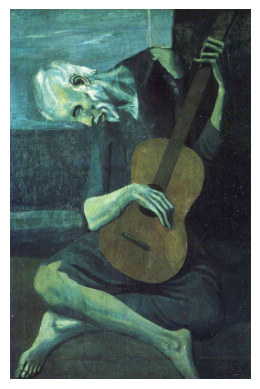

In [19]:
# Load the JSON file
with open('data_model/test_data.json', 'r') as file:
    data = json.load(file)

# Randomly select one entry from the JSON
selected_entry = random.choice(data)
image_path = selected_entry['label'].replace('.txt', '.jpg')
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [20]:
#Trying with first model
emotion=classify_emotion(image_path)
prompt_text=emotion
audio_filename = prompt_text+'.wav'
generate_audio(prompt_text, 'first_'+audio_filename,'model_base_best')

Generating audio with prompt sad saved as first_sad.wav


2024-08-20 23:06:24.067090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 23:06:24.126419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 23:06:24.126548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 23:06:24.128249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 23:06:24.137732: I tensorflow/core/platform/cpu_feature_guar

Saved the file


In [ ]:

audio = Audio('first_'+audio_filename)
display(audio)

In [ ]:
#Trying with second model
description=emotion_image_caption(image_path,emotion)
prompt_text=description
generate_audio(prompt_text, 'second_'+audio_filename,'model_blip_best')

In [ ]:
audio = Audio('second_'+audio_filename)
display(audio)

In [ ]:
#Trying with third model
prompt_text=enhance_musical_description(description)
generate_audio(prompt_text, 'third_'+audio_filename,'model_falcon_best')

In [ ]:
audio = Audio('third_'+audio_filename)
display(audio)

In [ ]:
#Trying with fourth model
generate_audio(prompt_text, 'fourth_'+audio_filename,'model_modify_best')

In [ ]:
audio = Audio('fourth_'+audio_filename)
display(audio)

# For checking the storage 

In [29]:
!du -h /home/jovyan|sort -rh

23G	/home/jovyan
12G	/home/jovyan/MSc_Project/synesthesia/audio
12G	/home/jovyan/MSc_Project/synesthesia
12G	/home/jovyan/MSc_Project
11G	/home/jovyan/.cache
7.9G	/home/jovyan/MSc_Project/synesthesia/audio/models
6.7G	/home/jovyan/.cache/huggingface/hub
6.7G	/home/jovyan/.cache/huggingface
2.6G	/home/jovyan/MSc_Project/synesthesia/audio/data_model
2.6G	/home/jovyan/.cache/pip/http
2.6G	/home/jovyan/.cache/pip
2.5G	/home/jovyan/.cache/huggingface/hub/models--ericzzz--falcon-rw-1b-instruct-openorca/blobs
2.5G	/home/jovyan/.cache/huggingface/hub/models--ericzzz--falcon-rw-1b-instruct-openorca
1.8G	/home/jovyan/.cache/huggingface/hub/models--Salesforce--blip-image-captioning-large/blobs
1.8G	/home/jovyan/.cache/huggingface/hub/models--Salesforce--blip-image-captioning-large
1.1G	/home/jovyan/.cache/pip/http/3
1.1G	/home/jovyan/.cache/huggingface/hub/models--facebook--musicgen-small/blobs
1.1G	/home/jovyan/.cache/huggingface/hub/models--facebook--musicgen-small
853M	/home/jovyan/.cache/hugg

In [2]:
rm -r /home/jovyan/.cache/pip/http-v2

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [12]:
!nvidia-smi

Tue Aug 13 11:12:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:17:00.0 Off |                    0 |
|  0%   25C    P8             31W /  300W |       3MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [28]:
!df -h

Filesystem                                                                                                                                                                                       Size  Used Avail Use% Mounted on
overlay                                                                                                                                                                                          893G  334G  559G  38% /
tmpfs                                                                                                                                                                                             64M     0   64M   0% /dev
tmpfs                                                                                                                                                                                            252G     0  252G   0% /sys/fs/cgroup
tmpfs                                                                                                      

In [44]:
!tar -czvf project.tar.gz /home/jovyan/MSc_Project/synesthesia/audio/

tar: Removing leading `/' from member names
/home/jovyan/MSc_Project/synesthesia/audio/
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/Untitled1-checkpoint.ipynb
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/Untitled2-checkpoint.ipynb
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/train_mod-checkpoint.py
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/train-checkpoint.py
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/run_mod-checkpoint.py
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/calc_fad-checkpoint.py
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/trial-checkpoint.ipynb
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/split_song-checkpoint.py
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/gen-checkpoint.py
/home/jovyan/MSc_Project/synesthesia/audio/.ipynb_checkpoints/data_pair-checkpoint

In [46]:
rm project.tar.gz

/bin/bash: line 1: zip: command not found


In [24]:
cd ..

/home/jovyan/MSc_Project/synesthesia


In [27]:
rm -r /home/jovyan/MSc_Project/synesthesia/rnn